**Summary:**
Increasing the number of missing celltypes, using random proportions pseudobulks. Then attempting to extract missing cell type information from residual. 

The residual is calculated in three different ways named: Residual (comparing NNLS calculated proportions to pseudobulks), Residual_diffbase (using different baseline being comapred to), and Residual_realref (using a "real" reference profile for cell lines).

**Hypothesis:**
Deleting cell types from NNLS reference will create a residual from which we can extract missing cell type information. 

**Deconv. Method:**
NNLS

**Factorization Methods:**
SVD, PCA, ICA, NMF

Note: This experiment was run with similar and not so similar cell-types: 

Similar cell-types removed: cells_to_miss = {0: [], 1: [1], 2: [1, 3], 3: [1, 3, 4], 4: [1, 3, 4, 2]}

Not Similar cell-types removed: cells_to_miss = {0: [], 1: [2], 2: [2,0], 3: [2, 0, 4], 4: [2, 0, 4, 3]}


In [26]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import sklearn as sk
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
from scipy.stats import kruskal
#import scikit_posthocs as sph
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

These parameters are set in EXP2.py.

In [27]:
#####################
### set the study ###
#####################
#paths:
res_name = f"MCT_pbmc_EXP2"
pseudo_name = "MCT_pbmc_EXP1"
files_path = "/../data/EXP1/"
cibersort_files = "/../data/EXP2/cibersort_results/pbmc3k/selected_cells/0_missing/CIBERSORTx_MCT_\
pbmc_EXP2_randomprop_nonoise_0missing_signal_inferred_phenoclasses.CIBERSORTx_MCT_pbmc_EXP2_\
randomprop_nonoise_0missing_signal_inferred_refsample.bm.K999.txt"
noise_type = "nonoise"
path_results = "/../results/EXP2/"
###### set your random seed, num missing cells, and num_samples for reference for reproducibility
random_seed = 88
prop_type = "random"
num_missing_cells = [0, 1, 2, 3, 4]
num_samples = 10000

#if you want cells deleted to be chosen randomly:
cells_to_miss_random = False
# cells_to_miss = {0: [], 1: [0], 2: [0,2], 3: [0, 2, 4], 4: [0, 2, 4, 3]}
cells_to_miss = {0: [], 1: [1], 2: [1,3], 3: [1, 3, 4], 4: [1, 3, 4, 2]}

#how to handle negative residual distribution for NMF
nmf_cut = "minimum_value" # minimum_value or at_0

#and kernel environment
kerne_name = "env_ml"

In [28]:
#Font for plots
font = {'fontname':'Arial'}

#Parameters into paths
actual_path = os.getcwd()
path = f"{actual_path}{files_path}"
aug_data_path = f"{actual_path}{files_path}"
cibersort_path = f"{actual_path}{cibersort_files}"
path_results = f"{actual_path}{path_results}"

## Import the previously processed datasets. 

In [29]:
#and as anndata object
adata_path = os.path.join(path, f"{pseudo_name}_adata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata = sc.read_h5ad(adata_path)
sn_adata

AnnData object with n_obs × n_vars = 2589 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'scpred_CellType', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_types_colors', 'leiden', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [30]:
Counter(sn_adata.obs["cell_types"])

Counter({'CD8 T': 328,
         'B': 342,
         'CD4 T': 1119,
         'FCGR3A Monocytes': 188,
         'NK': 164,
         'CD14 Monocytes': 448})

In [31]:
#excluding all cell types except 5 of interest
if pseudo_name == "MCT_snadp_EXP1_5CTnoise" or pseudo_name == "MCT_snadp_EXP1_5CTnonoise": #if pseudos have 5 cell types
    exclude = ['preadipocyte',
        'mesothelial cell',
        'pericyte cell',
        'fat cell',
        'endothelial cell',
        'endothelial cell of lymphatic vessel',
        'smooth muscle cell',
        'mast cell',
        'immature NK T cell',
        'stromal cell of endometrium',
        'neutrophil']
    sn_adata = sn_adata[~sn_adata.obs["cell_types"].isin(exclude), :]
#Tilde is “not”, so this reads like “var names that are not in exclude”
print(Counter(sn_adata.obs["cell_types"]))
# define the number of cells and the list of missing cell counts
num_cells = len(sn_adata.obs.cell_types.unique())
cell_order = sn_adata.obs.cell_types.unique()

Counter({'CD4 T': 1119, 'CD14 Monocytes': 448, 'B': 342, 'CD8 T': 328, 'FCGR3A Monocytes': 188, 'NK': 164})


Importing Pseudobulks:

In [32]:
#each pseudo file has:
## realisitc*200, cell_type_specific*1000*, random*200, equal*200
#so here we're defining the ranges to extract the bulks of choice.
bulk_range = dict()
bulk_range["realistic"] = range(0,200)
bulk_range["cell_type_specific"] = range(200,(50*num_cells)+200) #1000
bulk_range["random"] = range((50*num_cells)+200,(50*num_cells)+400) #1200
bulk_range["equal"] = range((50*num_cells)+400,(50*num_cells)+600) #1400
bulk_range["all"] = range(0,(50*num_cells)+600)

In [33]:
num_cell_type_specific = 50 * int(sn_adata.obs["cell_types"].unique().shape[0])
num_bulks = 200+num_cell_type_specific+200+200
num_bulks

900

In [34]:
#importing bulks to deconvolve
X_full, Y_full, gene_df, meta_df = sn_sc_preprocess.read_all_pseudobulk_files(data_path=aug_data_path, noise_type= f"{noise_type}_", file_name = pseudo_name, num_bulks_training = num_bulks, num_files=10, random_selection=False)
X_full.index = meta_df.index
Y_full.index = meta_df.index

0
1
2
3
4
5
6
7
8
9


(8000, 2)
(8000, 2)


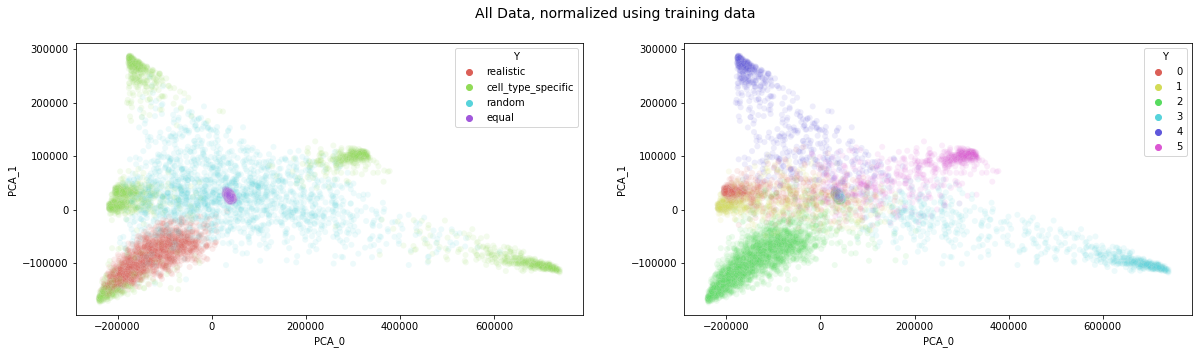

In [35]:
## plot samples (some of them for speed)
X_temp = X_full.iloc[0:8000]
Y_temp_p = Y_full.iloc[0:8000]
meta_temp = meta_df.iloc[0:8000]

plot_df = vp.get_pca_for_plotting(X_temp)

fig, axs = plt.subplots(1, 2, figsize=(20,5))

Y_temp = np.copy(Y_temp_p)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_temp.cell_prop_type.to_numpy(), axs[0], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[1], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

In [36]:
#cut to only the samples specified above.
idx_interest = np.where(meta_df.cell_prop_type == prop_type)[0]
pseudo_df = X_full.iloc[idx_interest]
prop_df = Y_full.iloc[idx_interest]
pseudo_df.index = range(0,len(pseudo_df))
prop_df.index = pseudo_df.index
meta_df.index = meta_df.index
pseudo_df.columns = sn_adata.var_names
pseudo_df

AL627309.1  AP006222.2  RP11-206L10.2  RP11-206L10.9  LINC00115  NOC2L  \
0           10.0         2.0           13.0            5.0       44.0  572.0   
1            7.0         2.0            0.0            6.0       45.0  724.0   
2           13.0         5.0            6.0           16.0       47.0  567.0   
3            4.0         5.0            3.0            5.0       57.0  655.0   
4           20.0         2.0            4.0            2.0       31.0  534.0   
...          ...         ...            ...            ...        ...    ...   
1995         2.0         4.0            3.0           12.0       55.0  737.0   
1996         6.0         3.0            2.0           19.0       56.0  738.0   
1997        17.0         6.0            2.0            2.0       29.0  530.0   
1998         9.0         9.0            4.0            9.0       37.0  578.0   
1999        24.0         1.0            6.0            4.0       34.0  582.0   

      KLHL17  PLEKHN1  RP11-54O7.17    HES4  ...  MT-ND4L   MT-ND4  MT-ND5  \
0       20.0      4.0           9.0   281.0  ...    740.0  24112.0  3523.0   
1       19.0     18.0           8.0  1081.0  ...    865.0  24838.0  4651.0   
2       18.0     16.0          10.0   881.0  ...    851.0  23873.0  4324.0   
3       11.0     13.0           6.0   646.0  ...    854.0  23856.0  3938.0   
4       15.0     13.0           4.0   485.0  ...    832.0  25233.0  4371.0   
...      ...      ...           ...     ...  ...      ...      ...     ...   
1995    22.0     23.0           6.0   934.0  ...    856.0  24254.0  4196.0   
1996    23.0      6.0          15.0  2346.0  ...    868.0  29224.0  5776.0   
1997    12.0     13.0           4.0   102.0  ...    798.0  24789.0  3928.0   
1998    16.0     15.0           3.0   424.0  ...    819.0  24436.0  4199.0   
1999     8.0     17.0           5.0   343.0  ...    799.0  24280.0  4155.0   

      MT-ND6   MT-CYB  AC145212.1  AL592183.1  AL354822.1  PNRC2-1  SRSF10-1  
0      390.0  19513.0        43.0       738.0        43.0    155.0     113.0  
1      591.0  21006.0        19.0       631.0        23.0    205.0     150.0  
2      474.0  20588.0        43.0       689.0        24.0    189.0     129.0  
3      468.0  19853.0        28.0       683.0        22.0    179.0     121.0  
4      508.0  21909.0        33.0       653.0        19.0    237.0     126.0  
...      ...      ...         ...         ...         ...      ...       ...  
1995   486.0  20013.0        34.0       663.0        24.0    196.0     115.0  
1996   542.0  23331.0        27.0       669.0        36.0    181.0     181.0  
1997   516.0  20661.0        24.0       707.0        10.0    207.0     138.0  
1998   537.0  21359.0        30.0       661.0        12.0    198.0     113.0  
1999   531.0  21827.0        21.0       678.0        12.0    214.0     128.0  

[2000 rows x 13714 columns]

In [37]:
#cutting to 1000 pseudos w/ random seed
random.seed(seed=random_seed)
idx_to_keep = np.random.choice(pseudo_df.index, 1000, replace=False)
#cutting both props and pseudos
pseudo_df = pseudo_df.iloc[idx_to_keep]
prop_df = prop_df.iloc[idx_to_keep]
pseudo_df

AL627309.1  AP006222.2  RP11-206L10.2  RP11-206L10.9  LINC00115  NOC2L  \
1059        19.0         8.0            6.0            7.0       34.0  582.0   
929          8.0         2.0            3.0            4.0       42.0  701.0   
1506        20.0         8.0            3.0           11.0       51.0  578.0   
237         31.0         8.0            2.0           14.0       33.0  591.0   
1371         9.0         0.0            3.0            8.0       55.0  648.0   
...          ...         ...            ...            ...        ...    ...   
1573        23.0         4.0            4.0           14.0       54.0  613.0   
1132         9.0         4.0            5.0            6.0       37.0  602.0   
1998         9.0         9.0            4.0            9.0       37.0  578.0   
1988         7.0         3.0           12.0            7.0       39.0  651.0   
1167        18.0         5.0            4.0           10.0       45.0  529.0   

      KLHL17  PLEKHN1  RP11-54O7.17    HES4  ...  MT-ND4L   MT-ND4  MT-ND5  \
1059    12.0     15.0          15.0   923.0  ...    802.0  26434.0  4813.0   
929     19.0     16.0          11.0   982.0  ...    881.0  24704.0  4466.0   
1506     8.0     23.0          13.0  1047.0  ...    781.0  25360.0  4773.0   
237     19.0     19.0           9.0  1081.0  ...    852.0  24709.0  4791.0   
1371    13.0     13.0           2.0   600.0  ...    821.0  22967.0  3998.0   
...      ...      ...           ...     ...  ...      ...      ...     ...   
1573    19.0      8.0          12.0  1757.0  ...    822.0  26167.0  5128.0   
1132    18.0      8.0           7.0  1025.0  ...    869.0  27033.0  4868.0   
1998    16.0     15.0           3.0   424.0  ...    819.0  24436.0  4199.0   
1988    20.0     12.0           3.0   817.0  ...    798.0  24564.0  3830.0   
1167    16.0     24.0           6.0   296.0  ...    893.0  21365.0  3824.0   

      MT-ND6   MT-CYB  AC145212.1  AL592183.1  AL354822.1  PNRC2-1  SRSF10-1  
1059   552.0  23069.0        34.0       628.0        29.0    198.0     122.0  
929    508.0  20935.0        23.0       699.0        28.0    217.0     143.0  
1506   539.0  21418.0        44.0       577.0        28.0    222.0     134.0  
237    532.0  21917.0        34.0       621.0        19.0    188.0     109.0  
1371   500.0  19232.0        33.0       679.0        16.0    190.0     105.0  
...      ...      ...         ...         ...         ...      ...       ...  
1573   505.0  22174.0        52.0       614.0        36.0    191.0     137.0  
1132   526.0  22346.0        39.0       703.0        26.0    243.0     178.0  
1998   537.0  21359.0        30.0       661.0        12.0    198.0     113.0  
1988   402.0  19331.0        29.0       790.0        23.0    183.0     125.0  
1167   505.0  18578.0        27.0       620.0         8.0    142.0      59.0  

[1000 rows x 13714 columns]

Normalizing pseudobullks:

In [38]:
#clipping before scaling to 95th pecentile
pseudo_copy = pseudo_df.copy() #keeping genes
pseudo_df = pseudo_df.values #np array
clip_upper = np.quantile(pseudo_df, 0.95)
pseudo_df = np.clip(pseudo_df, 0, clip_upper)
#and normalize to values between 0 and 1
scaler = MinMaxScaler()
scaler.fit(pseudo_df)
normalized_pseudo_df = scaler.transform(pseudo_df)
normalized_pseudo_df = pd.DataFrame(normalized_pseudo_df, 
                            columns = pseudo_copy.columns, index= pseudo_copy.index)
normalized_pseudo_df   

AL627309.1  AP006222.2  RP11-206L10.2  RP11-206L10.9  LINC00115  \
1059    0.290323    0.470588       0.214286       0.233333   0.385965   
929     0.112903    0.117647       0.107143       0.133333   0.526316   
1506    0.306452    0.470588       0.107143       0.366667   0.684211   
237     0.483871    0.470588       0.071429       0.466667   0.368421   
1371    0.129032    0.000000       0.107143       0.266667   0.754386   
...          ...         ...            ...            ...        ...   
1573    0.354839    0.235294       0.142857       0.466667   0.736842   
1132    0.129032    0.235294       0.178571       0.200000   0.438596   
1998    0.129032    0.529412       0.142857       0.300000   0.438596   
1988    0.096774    0.176471       0.428571       0.233333   0.473684   
1167    0.274194    0.294118       0.142857       0.333333   0.578947   

         NOC2L    KLHL17   PLEKHN1  RP11-54O7.17      HES4  ...   MT-ND4L  \
1059  0.451389  0.289474  0.454545      0.517241  0.464017  ...  0.428571   
929   0.726852  0.473684  0.484848      0.379310  0.495704  ...  0.697279   
1506  0.442130  0.184211  0.696970      0.448276  0.530612  ...  0.357143   
237   0.472222  0.473684  0.575758      0.310345  0.548872  ...  0.598639   
1371  0.604167  0.315789  0.393939      0.068966  0.290548  ...  0.493197   
...        ...       ...       ...           ...       ...  ...       ...   
1573  0.523148  0.473684  0.242424      0.413793  0.911923  ...  0.496599   
1132  0.497685  0.447368  0.242424      0.241379  0.518797  ...  0.656463   
1998  0.442130  0.394737  0.454545      0.103448  0.196026  ...  0.486395   
1988  0.611111  0.500000  0.363636      0.103448  0.407089  ...  0.414966   
1167  0.328704  0.394737  0.727273      0.206897  0.127282  ...  0.738095   

      MT-ND4  MT-ND5    MT-ND6  MT-CYB  AC145212.1  AL592183.1  AL354822.1  \
1059     0.0     0.0  0.615385     0.0    0.402597    0.326590    0.446154   
929      0.0     0.0  0.498674     0.0    0.259740    0.531792    0.430769   
1506     0.0     0.0  0.580902     0.0    0.532468    0.179191    0.430769   
237      0.0     0.0  0.562334     0.0    0.402597    0.306358    0.292308   
1371     0.0     0.0  0.477454     0.0    0.389610    0.473988    0.246154   
...      ...     ...       ...     ...         ...         ...         ...   
1573     0.0     0.0  0.490716     0.0    0.636364    0.286127    0.553846   
1132     0.0     0.0  0.546419     0.0    0.467532    0.543353    0.400000   
1998     0.0     0.0  0.575597     0.0    0.350649    0.421965    0.184615   
1988     0.0     0.0  0.217507     0.0    0.337662    0.794798    0.353846   
1167     0.0     0.0  0.490716     0.0    0.311688    0.303468    0.123077   

       PNRC2-1  SRSF10-1  
1059  0.467836  0.452174  
929   0.578947  0.543478  
1506  0.608187  0.504348  
237   0.409357  0.395652  
1371  0.421053  0.378261  
...        ...       ...  
1573  0.426901  0.517391  
1132  0.730994  0.695652  
1998  0.467836  0.413043  
1988  0.380117  0.465217  
1167  0.140351  0.178261  

[1000 rows x 13714 columns]

## Selecting cells to delete:

In [39]:
# if selected to choose cells randomly, else just keep the cells_to_miss
if cells_to_miss_random:
    cells_to_miss = sn_sc_preprocess.select_cells_missing(sn_adata, num_missing_cells, random_seed)
cells_to_miss    

{0: [], 1: [1], 2: [1, 3], 3: [1, 3, 4], 4: [1, 3, 4, 2]}

## Creating reference profiles and Importing Bulks:


1. ref_raw is the sum of each gene expression per num_samples of each cell type. This is not scaled (raw). Once it is clipped and scaled with MinMax(), it becomes:
2. ref_df, which is used in NNLS. Scaled 0-1.

In [40]:
# Making cell type reference without scaling
cell_types = sn_adata.obs["cell_types"].unique()
gene_ids = sn_adata.var_names
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)
for cell_type in cell_types:
    cell_df = sn_adata[sn_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw

CD8 T       B   CD4 T  FCGR3A Monocytes      NK  \
AL627309.1       27.0     0.0    16.0               0.0     0.0   
AP006222.2       28.0     0.0    10.0               0.0     0.0   
RP11-206L10.2     0.0    70.0    12.0               0.0     0.0   
RP11-206L10.9     0.0     0.0     0.0              59.0     0.0   
LINC00115        30.0    81.0    43.0              88.0   117.0   
...               ...     ...     ...               ...     ...   
AC145212.1       24.0    53.0    36.0             118.0     0.0   
AL592183.1     1103.0  1772.0  1480.0            1316.0  1395.0   
AL354822.1        0.0    45.0    18.0             159.0     0.0   
PNRC2-1         556.0   272.0   503.0             441.0   286.0   
SRSF10-1        250.0   305.0   336.0             509.0   118.0   

               CD14 Monocytes  
AL627309.1              121.0  
AP006222.2               21.0  
RP11-206L10.2             0.0  
RP11-206L10.9            44.0  
LINC00115                79.0  
...                       ...  
AC145212.1              162.0  
AL592183.1              990.0  
AL354822.1               18.0  
PNRC2-1                 272.0  
SRSF10-1                  0.0  

[13714 rows x 6 columns]

In [41]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw.values
clip_upper = np.quantile(ref_raw_val, 0.95)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = cell_types)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = cell_types)
ref_df

CD8 T         B     CD4 T  FCGR3A Monocytes        NK  \
AL627309.1     0.007162  0.000000  0.004244          0.000000  0.000000   
AP006222.2     0.007427  0.000000  0.002653          0.000000  0.000000   
RP11-206L10.2  0.000000  0.018568  0.003183          0.000000  0.000000   
RP11-206L10.9  0.000000  0.000000  0.000000          0.015650  0.000000   
LINC00115      0.007958  0.021485  0.011406          0.023342  0.031034   
...                 ...       ...       ...               ...       ...   
AC145212.1     0.006366  0.014058  0.009549          0.031300  0.000000   
AL592183.1     0.292573  0.470027  0.392573          0.349072  0.370027   
AL354822.1     0.000000  0.011936  0.004775          0.042175  0.000000   
PNRC2-1        0.147480  0.072149  0.133422          0.116976  0.075862   
SRSF10-1       0.066313  0.080902  0.089125          0.135013  0.031300   

               CD14 Monocytes  
AL627309.1           0.032095  
AP006222.2           0.005570  
RP11-206L10.2        0.000000  
RP11-206L10.9        0.011671  
LINC00115            0.020955  
...                       ...  
AC145212.1           0.042971  
AL592183.1           0.262599  
AL354822.1           0.004775  
PNRC2-1              0.072149  
SRSF10-1             0.000000  

[13714 rows x 6 columns]

Read in the barcoee genes from CIBERSORTx:

In [42]:
cibersort_df = pd.read_csv(cibersort_path, sep="\t")
cibersort_genes = cibersort_df["NAME"].values.tolist()
#and set intersection of gene_ids (single-cell) and cibersort:
gene_notin = np.setdiff1d(gene_ids, cibersort_genes)

#keep genes in both and check number
gene_ids = [ele for ele in gene_ids if ele not in gene_notin]
len(gene_ids)     

1306

In [43]:
#cutting to cibersort genes 
pseudo_copy  = pseudo_copy[gene_ids]
ref_raw = ref_raw.loc[gene_ids,:]
ref_df = ref_df.loc[gene_ids,:]
normalized_pseudo_df = normalized_pseudo_df[gene_ids]
normalized_pseudo_df

NOC2L      HES4      SDF4    UBE2J2      MIB2      NADK      GNB1  \
1059  0.451389  0.464017  0.233945  0.555224  0.323223  0.325387  0.436685   
929   0.726852  0.495704  0.478593  0.579104  0.452133  0.318236  0.297952   
1506  0.442130  0.530612  0.273700  0.408955  0.235071  0.330155  0.403166   
237   0.472222  0.548872  0.334098  0.513433  0.299526  0.442193  0.457169   
1371  0.604167  0.290548  0.531346  0.635821  0.428436  0.227652  0.255121   
...        ...       ...       ...       ...       ...       ...       ...   
1573  0.523148  0.911923  0.244648  0.391045  0.153555  0.593564  0.603352   
1132  0.497685  0.518797  0.226300  0.450746  0.184834  0.297974  0.309125   
1998  0.442130  0.196026  0.342508  0.671642  0.331754  0.179976  0.264432   
1988  0.611111  0.407089  0.228593  0.367164  0.251185  0.226460  0.181564   
1167  0.328704  0.127282  0.564220  0.456716  0.440758  0.227652  0.257914   

        KCNAB2     VAMP3      RBP7  ...    IL10RB    IFNGR2      TTC3  \
1059  0.454874  0.322949  0.323264  ...  0.347012  0.698867  0.458617   
929   0.415162  0.294912  0.180710  ...  0.297056  0.511628  0.588121   
1506  0.440433  0.373832  0.402756  ...  0.367529  0.886702  0.313535   
237   0.523466  0.426791  0.534181  ...  0.436218  0.943948  0.266796   
1371  0.445848  0.231568  0.242713  ...  0.252453  0.571258  0.395326   
...        ...       ...       ...  ...       ...       ...       ...   
1573  0.731047  0.572170  0.665077  ...  0.620874  1.000000  0.534567   
1132  0.263538  0.311526  0.246953  ...  0.314897  0.597496  0.602726   
1998  0.301444  0.196262  0.204028  ...  0.155219  0.429338  0.353457   
1988  0.353791  0.212876  0.163752  ...  0.251561  0.627311  0.484907   
1167  0.435018  0.248183  0.419184  ...  0.206066  0.621348  0.429406   

           MX2    NDUFV3      PDXK      PFKL     DIP2A     S100B  AL592183.1  
1059  0.488462  0.436735  0.357831  0.330337  0.267135  0.154605    0.326590  
929   0.412500  0.375510  0.295181  0.330337  0.469244  0.468202    0.531792  
1506  0.452885  0.495238  0.428916  0.347191  0.321617  0.236294    0.179191  
237   0.504808  0.515646  0.485542  0.378652  0.362039  0.294408    0.306358  
1371  0.290385  0.314286  0.274699  0.273034  0.453427  0.589364    0.473988  
...        ...       ...       ...       ...       ...       ...         ...  
1573  0.666346  0.643537  0.707229  0.521348  0.265378  0.170504    0.286127  
1132  0.485577  0.406803  0.359036  0.373034  0.209139  0.135965    0.543353  
1998  0.344231  0.239456  0.180723  0.164045  0.240773  0.309759    0.421965  
1988  0.221154  0.263946  0.263855  0.302247  0.228471  0.267544    0.794798  
1167  0.305769  0.349660  0.296386  0.115730  0.495606  0.546601    0.303468  

[1000 rows x 1306 columns]

TSNEs of Pseuboulks and References: We expect the point of the References (cells) to be in separated within the pseudobulks encoding.

===> Finding 180 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.34 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=1.00, lr=1000.00 for 500 iterations...
Iteration   50, KL divergence 0.8003, 50 iterations in 0.5866 sec
Iteration  100, KL divergence 0.7881, 50 iterations in 0.4084 sec
Iteration  150, KL divergence 0.7838, 50 iterations in 0.4080 sec
Iteration  200, KL divergence 0.7836, 50 iterations in 0.4218 sec
Iteration  250, KL divergence 0.7831, 50 iterations in 0.4088 sec
Iteration  300, KL divergence 0.7818, 50 iterations in 0.4085 sec
Iteration  350, KL divergence 0.7821, 50 iterations in 0.4098 sec
Iteration  400, KL divergence 0.7822, 50 iterations in 0.4094 sec
Iteration  450, KL divergence 0.7822, 50 iterations in 0.4092 sec
Iteration  500, KL divergence 0.7824, 50 iterations in 0.4093 sec
   --> Time elapsed: 4.28 seconds
===> Finding 15 nearest n

Perplexity value 60 is too high. Using perplexity 1.67 instead


===> Finding 5 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.00, lr=6.00 for 500 iterations...
Iteration   50, KL divergence 0.0379, 50 iterations in 0.5333 sec
Iteration  100, KL divergence 0.0347, 50 iterations in 0.3885 sec
Iteration  150, KL divergence 0.0393, 50 iterations in 0.3939 sec
Iteration  200, KL divergence 0.0424, 50 iterations in 0.3972 sec
Iteration  250, KL divergence 0.0435, 50 iterations in 0.3886 sec
Iteration  300, KL divergence 0.0365, 50 iterations in 0.3888 sec
Iteration  350, KL divergence 0.0390, 50 iterations in 0.3885 sec
Iteration  400, KL divergence 0.0344, 50 iterations in 0.3886 sec
Iteration  450, KL divergence 0.0375, 50 iterations in 0.3888 sec
Iteration  500, KL divergence 0.0383, 50 iterations in 0.3888 sec
   --> Time elapsed: 4.05 seconds
===> Finding 6 nearest neighbors in existi

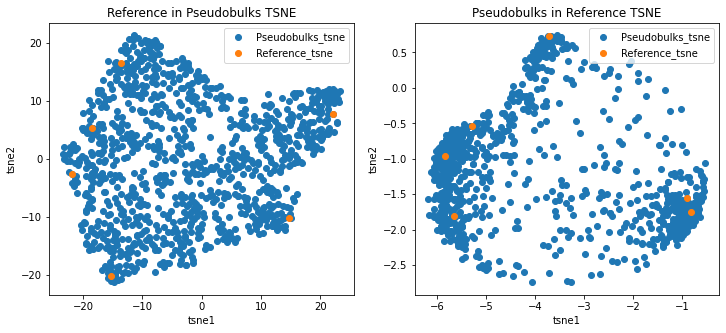

In [44]:
#tsne plots of reference dataframes projected in normalized pseudobulks TSNE 
#figures
plt.figure(figsize=(12, 5))
#data used
x_train = normalized_pseudo_df.values
x_test = ref_df.T.values
#compute the affinities between data points
affinities_train = affinity.PerplexityBasedNN(
    x_train,
    perplexity=60,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
#initialize coordinates for embedd.
init_train = initialization.pca(x_train, random_state=42)
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    verbose=True,
)
#optimize embedding
embedding_train = embedding_train.optimize(n_iter=500)
#transform both in train embedd.
tsne_train = embedding_train.transform(x_train)
tsne_test = embedding_train.transform(x_test)
plt.subplot(1, 2, 1)
plt.scatter(tsne_train[:,0], tsne_train[:,1], label = "Pseudobulks_tsne" )
plt.scatter(tsne_test[:,0], tsne_test[:,1], label = "Reference_tsne" )
plt.title(f"Reference in Pseudobulks TSNE")
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.legend()
#data used (switching)
x_train = ref_df.T.values
x_test = normalized_pseudo_df.values
#compute the affinities between data points
affinities_train = affinity.PerplexityBasedNN(
    x_train,
    perplexity=60,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
#initialize coordinates for embedd.
init_train = initialization.pca(x_train, random_state=42)
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    verbose=True,
)
#optimize embedding
embedding_train = embedding_train.optimize(n_iter=500)
#transform both in train embedd.
tsne_train = embedding_train.transform(x_train)
tsne_test = embedding_train.transform(x_test)
plt.subplot(1, 2, 2)
plt.scatter(tsne_test[:,0], tsne_test[:,1], label = "Pseudobulks_tsne" )
plt.scatter(tsne_train[:,0], tsne_train[:,1], label = "Reference_tsne" )
plt.title(f"Pseudobulks in Reference TSNE")
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.legend()
plt.show()

In [45]:
# Putting together all reference expression, scaled and unscaled, and props.
all_refs = dict()
all_prop_refs = dict()
all_prop_refs_rebalanced = dict()
all_refs_raw = dict()
all_refs_av = dict()
#with no cell missing is just ref_df
all_refs[0] = ref_df
all_refs_raw[0] = ref_raw
all_prop_refs[0] = prop_df
all_prop_refs_rebalanced[0] = prop_df
#assigning the rest in a loop
for num in num_missing_cells[1:]:
    #dropping cell types missing from references
    all_refs[num] = ref_df.drop(ref_df.columns[cells_to_miss[num]], axis=1)
    all_refs_raw[num] = ref_raw.drop(ref_raw.columns[cells_to_miss[num]], axis=1)
    all_prop_refs[num] = prop_df.drop(prop_df.columns[cells_to_miss[num]], axis=1) 
    all_prop_refs_rebalanced[num] = all_prop_refs[num]
    for idx,sample in all_prop_refs_rebalanced[num].iterrows():
        tot = np.sum(sample) #making them equal 1
        sample = sample / tot

## NNLS Deconvolution:

In [46]:
calc_prop_tot, calc_res_tot, custom_res_tot, comparison_prop_tot, missing_cell_tot  = vp.calc_nnls(all_refs, prop_df, normalized_pseudo_df, num_missing_cells, cells_to_miss)

Exp 0
Exp 1
Exp 2
Exp 3
Exp 4


Evalutating NNLS Performance:

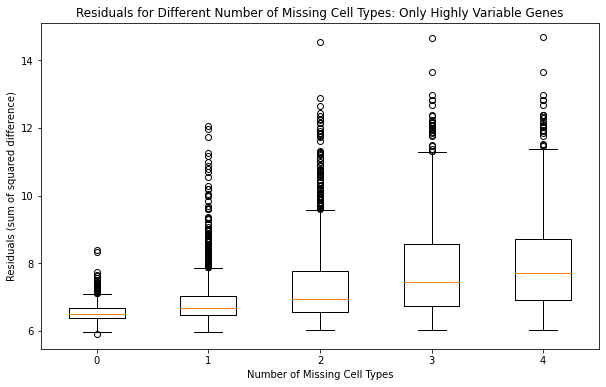

In [47]:
#Distribution of residuals as the sum of squared difference from NNLS
residuals = [calc_res_tot[exp] for exp in num_missing_cells]

plt.figure(figsize=(10, 6))
plt.boxplot(residuals, labels=num_missing_cells)
plt.xlabel('Number of Missing Cell Types')
plt.ylabel('Residuals (sum of squared difference)')
plt.title('Residuals for Different Number of Missing Cell Types: Only Highly Variable Genes')
## nnls(A, b)
## /Ax -b/^2
plt.show()

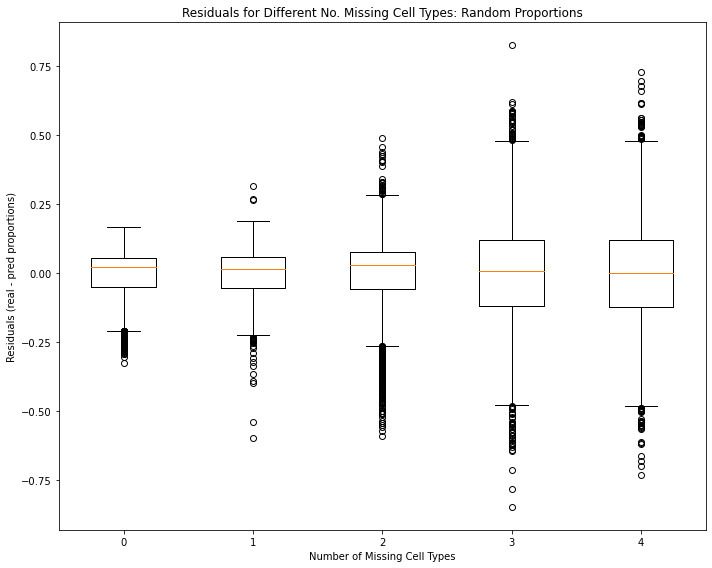

In [48]:
#Distribution of residuals as the difference between calculated and real proportions.
fig, ax = plt.subplots(figsize=(10, 8))

# List to store all the residual values
residual_values = []

# Iterate over the dataframes and extract the residual values
for num_cells in num_missing_cells:
    df = custom_res_tot[num_cells]
    residuals = df.values.flatten()  # Flatten the dataframe to a 1D array
    residual_values.append(residuals)

# Plot the box and whisker plot for all the residuals
ax.boxplot(residual_values, labels=num_missing_cells)
ax.set_title("Residuals for Different No. Missing Cell Types: Random Proportions")
ax.set_xlabel("Number of Missing Cell Types")
ax.set_ylabel("Residuals (real - pred proportions)")

plt.tight_layout()
plt.show()

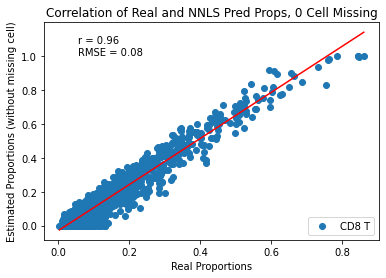

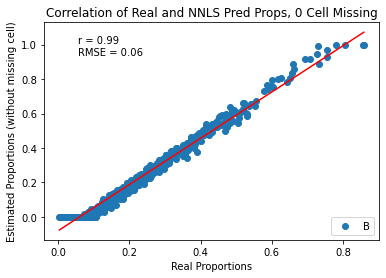

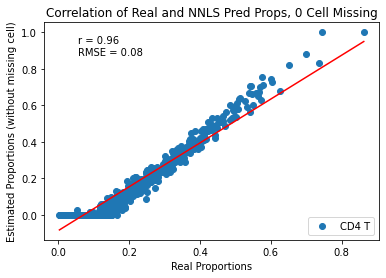

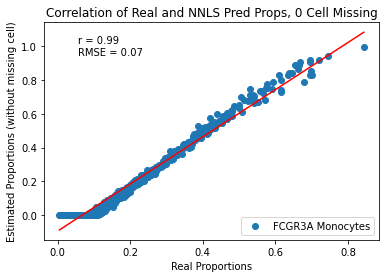

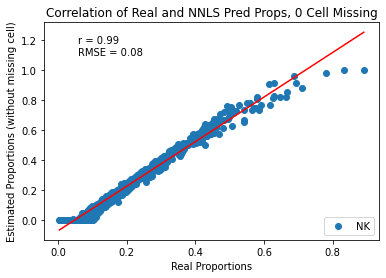

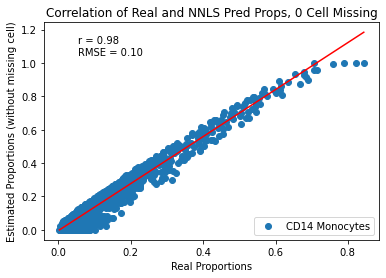

In [49]:
#Evaluation performance with no cell types missing, expect to be very close to 1.
num = 0 
for col_cell in all_prop_refs[num].columns:
    x = all_prop_refs_rebalanced[num][col_cell].values.astype(float)
    y = calc_prop_tot[num][col_cell].values.astype(float)
    correlation_coefficient = np.corrcoef(x, y)[0,1]
    plt.scatter(x, y, label= f"{col_cell}")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = "red")
    r, p = stats.pearsonr(x, y)
    # Calculate RMSE
    rmse = vp.rmse(x,y)
    
    # And annotate
    plt.annotate(f'r = {r:.2f}\nRMSE = {rmse:.2f}', xy=(0.1, 0.85), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and NNLS Pred Props, {num} Cell Missing')
    plt.legend(loc='lower right')
    plt.show()

Real Proportions shape: (1000, 6)
Estimated Proportions shape: (1000, 6)


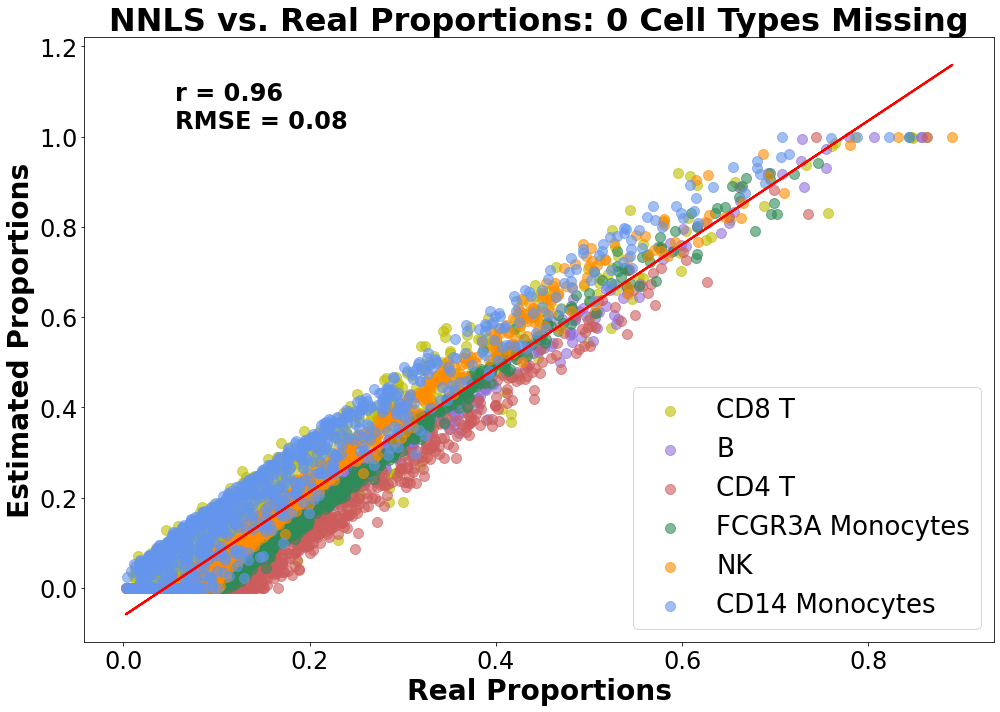

Real Proportions shape: (1000, 5)
Estimated Proportions shape: (1000, 5)


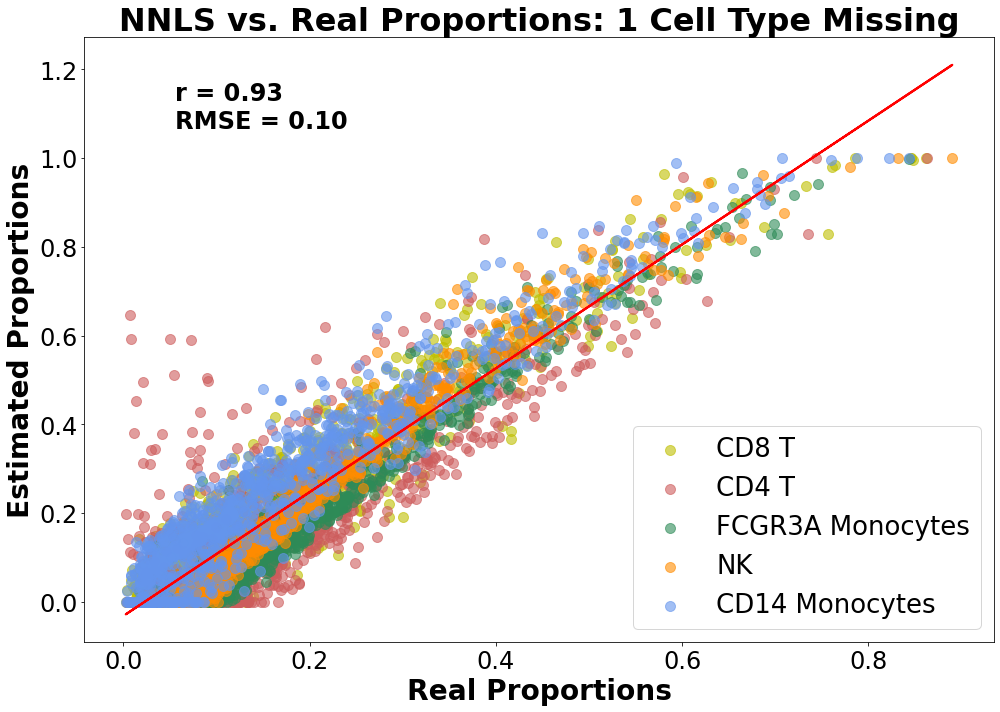

Real Proportions shape: (1000, 4)
Estimated Proportions shape: (1000, 4)


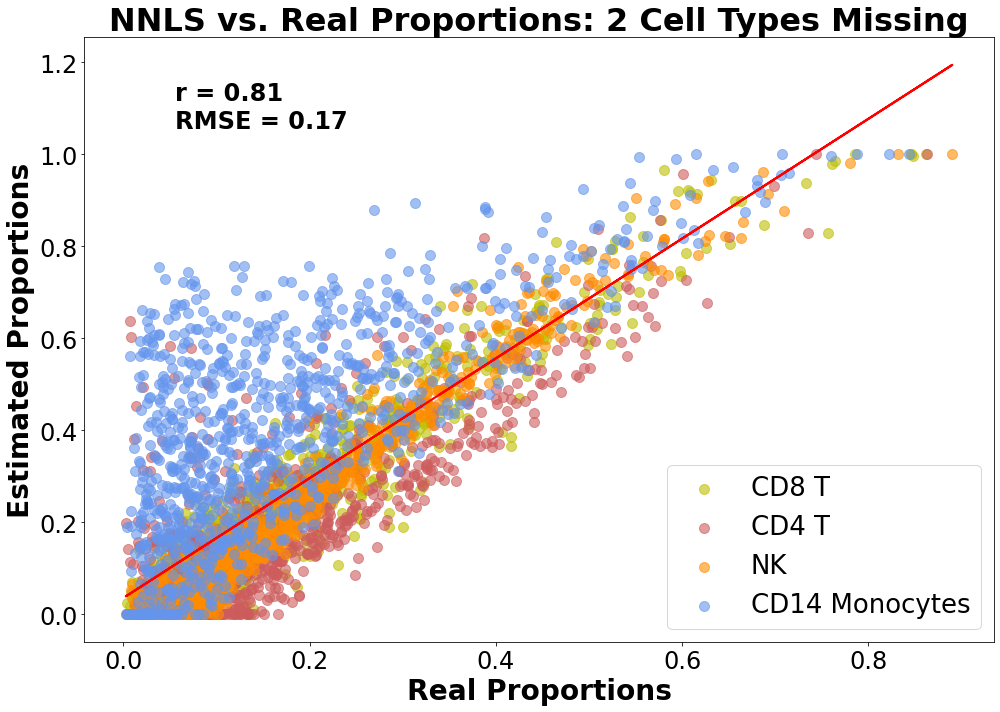

Real Proportions shape: (1000, 3)
Estimated Proportions shape: (1000, 3)


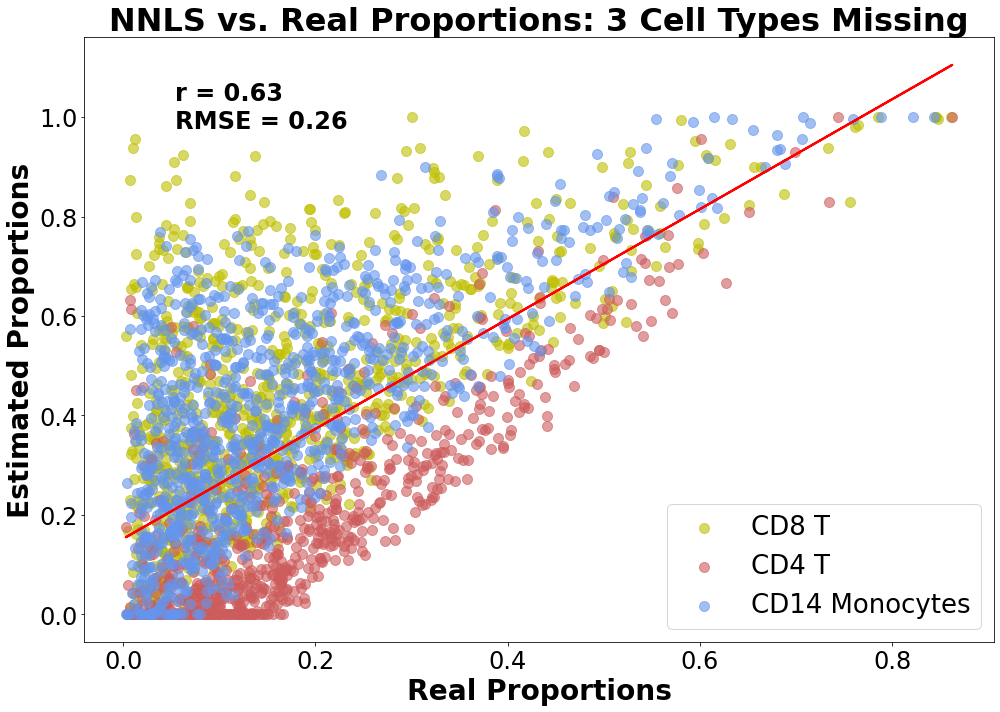

Real Proportions shape: (1000, 2)
Estimated Proportions shape: (1000, 2)


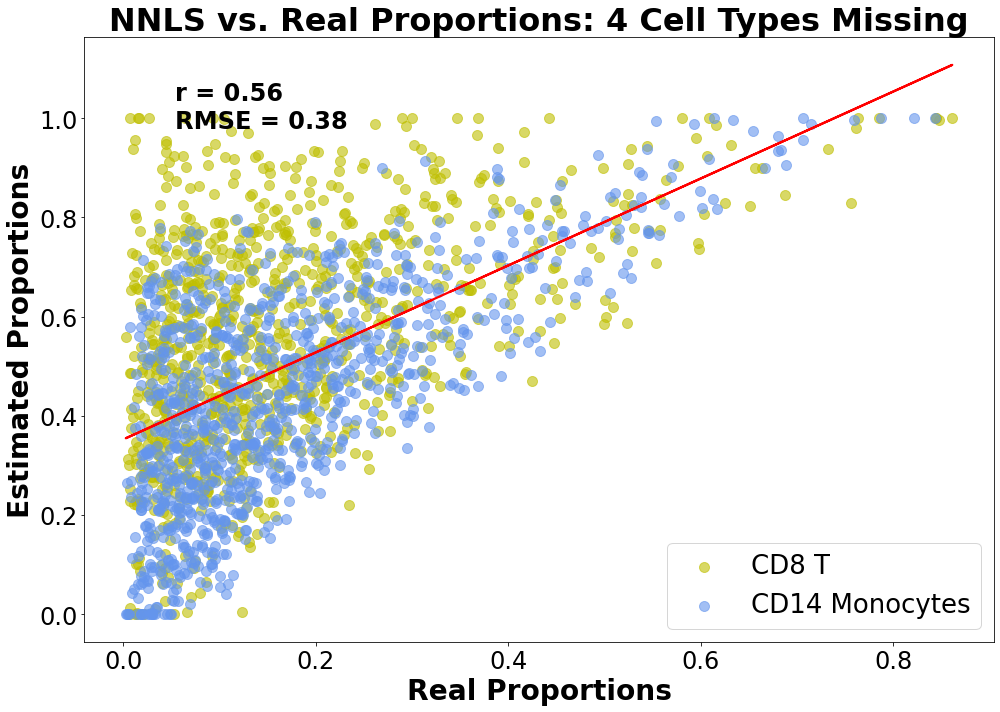

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Define the custom font properties
font = {'family': 'Arial', 'weight': 'bold', 'size': 22}

# Custom colors for cell types
custom_colors = ['mediumpurple', 'cornflowerblue', 'indianred', 'y', 'seagreen', 'darkorange']

# Collecting all unique cell types across num_missing_cells
all_cell_types = set()
for num in num_missing_cells:
    all_cell_types.update(all_prop_refs_rebalanced[num].columns.tolist())
all_cell_types = sorted(all_cell_types)
# Creating a fixed color mapping for all cell types
color_map = {cell_type: custom_colors[i % len(custom_colors)] for i, cell_type in enumerate(all_cell_types)}

# Loop through each `num_missing_cells` to plot the scatter plots
for num in num_missing_cells:
    
    real_proportions = all_prop_refs_rebalanced[num].values.astype(float)
    estimated_proportions = calc_prop_tot[num].values.astype(float)
    cell_types = all_prop_refs_rebalanced[num].columns.tolist()

    # Print the shapes of the matrices
    print("Real Proportions shape:", real_proportions.shape)
    print("Estimated Proportions shape:", estimated_proportions.shape)
    
    correlation_coefficient = np.corrcoef(real_proportions, estimated_proportions)[0, 1]
    
    # Scatter plot
    fig, ax = plt.subplots(figsize=(14, 10))  # Increase the figure size for better readability
    for cell_type in cell_types:
        x = real_proportions[:, cell_types.index(cell_type)]
        y = estimated_proportions[:, cell_types.index(cell_type)]
        
        # Use the fixed color mapping for consistent coloring
        color = color_map[cell_type]
        
        ax.scatter(x, y, label=cell_type, color=color, alpha=0.6, s=100)  # Increase marker size for clarity
    
    # Fit a regression line
    m, b = np.polyfit(real_proportions.flatten(), estimated_proportions.flatten(), 1)
    plt.plot(real_proportions.flatten(), m * real_proportions.flatten() + b, color="red", linewidth=2.2)  # Make the regression line thicker
    
    # Calculate r and RMSE
    r, p = stats.pearsonr(real_proportions.flatten(), estimated_proportions.flatten())
    rmse = np.sqrt(((real_proportions - estimated_proportions) ** 2).mean())
    
    # Annotate with r and RMSE
    plt.annotate(f'r = {r:.2f}\nRMSE = {rmse:.2f}', xy=(0.1, 0.85), xycoords='axes fraction', fontsize=24, weight='bold')
    
    # Set axis labels and title with increased font size
    plt.xlabel('Real Proportions', fontsize=28, fontweight='bold')
    plt.ylabel('Estimated Proportions', fontsize=28, fontweight='bold')
    if num == 1:
        plt.title(f'NNLS vs. Real Proportions: {num} Cell Type Missing', fontsize=32, fontweight='bold')
    else:    
        plt.title(f'NNLS vs. Real Proportions: {num} Cell Types Missing', fontsize=32, fontweight='bold')

    # Increase legend font size
    plt.legend(loc='lower right', fontsize=26)  # Show the cell type labels in the legend

    # Increase tick label size
    ax.tick_params(axis='both', which='major', labelsize=24)  # Adjust the tick label size

    # Show the plot
    plt.tight_layout()
    plt.show()

Recreate Matrices:

In [26]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
recreated_mat_all = dict()
for num in num_missing_cells:
        recreated_mat_all[num] = pd.DataFrame(all_refs[num] @ calc_prop_tot[num].T)
        recreated_mat_all[num] = recreated_mat_all[num].T
        recreated_mat_all[num].columns = gene_ids
recreated_mat_all[0]    

NOC2L      HES4      SDF4    UBE2J2      MIB2      NADK      GNB1  \
0    0.277409  0.228994  0.356925  0.325019  0.232287  0.215932  0.470884   
1    0.366682  0.237998  0.608186  0.363113  0.389290  0.216784  0.411864   
2    0.292153  0.284347  0.403501  0.310402  0.201398  0.242725  0.486250   
3    0.297826  0.287552  0.453457  0.312844  0.233586  0.256877  0.507558   
4    0.337155  0.098201  0.635468  0.349616  0.389950  0.152690  0.350228   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.335143  0.568849  0.396876  0.292193  0.140779  0.396657  0.645029   
996  0.303360  0.265873  0.348687  0.310421  0.144510  0.191776  0.389019   
997  0.275598  0.057175  0.419554  0.341449  0.286717  0.112821  0.338839   
998  0.326388  0.161298  0.367874  0.285124  0.195402  0.158721  0.306880   
999  0.331433  0.101926  0.686204  0.350650  0.407612  0.167647  0.384849   

       KCNAB2     VAMP3      RBP7  ...    IL10RB    IFNGR2      TTC3  \
0    0.328576  0.270182  0.395461  ...  0.396802  0.505852  0.316854   
1    0.364440  0.273954  0.204385  ...  0.390050  0.382751  0.493961   
2    0.356929  0.322771  0.494774  ...  0.450444  0.619878  0.369628   
3    0.377695  0.338508  0.562966  ...  0.464296  0.667935  0.362052   
4    0.343565  0.223018  0.290607  ...  0.317425  0.405952  0.446459   
..        ...       ...       ...  ...       ...       ...       ...   
995  0.441366  0.487253  0.673458  ...  0.656249  0.890985  0.427940   
996  0.305916  0.278025  0.247131  ...  0.403487  0.450169  0.463883   
997  0.279173  0.169553  0.214055  ...  0.266539  0.298437  0.352520   
998  0.282151  0.197309  0.196725  ...  0.343783  0.549301  0.402733   
999  0.369908  0.252304  0.417435  ...  0.338271  0.471056  0.434058   

          MX2    NDUFV3      PDXK      PFKL     DIP2A     S100B  AL592183.1  
0    0.562933  0.282743  0.267308  0.342867  0.142981  0.084660    0.298866  
1    0.408022  0.250823  0.227918  0.356578  0.249390  0.485149    0.349969  
2    0.505777  0.326094  0.319571  0.377033  0.161853  0.190735    0.314449  
3    0.505033  0.345014  0.340944  0.377142  0.182387  0.252040    0.304337  
4    0.306868  0.230934  0.205976  0.277259  0.250987  0.529934    0.346805  
..        ...       ...       ...       ...       ...       ...         ...  
995  0.613485  0.448250  0.468229  0.544573  0.170732  0.206781    0.315820  
996  0.421027  0.261751  0.245971  0.374935  0.138696  0.170720    0.368208  
997  0.425188  0.195235  0.161358  0.245592  0.161670  0.189518    0.324468  
998  0.262981  0.186578  0.189089  0.358858  0.136928  0.231401    0.412719  
999  0.319414  0.269429  0.245499  0.269960  0.271656  0.587216    0.325183  

[1000 rows x 1306 columns]

And saving results for plots:

In [27]:
# Iterate through num_missing_cells
real_df = pd.DataFrame()
predicted_df = pd.DataFrame()

for num in num_missing_cells:

    real_proportions = all_prop_refs_rebalanced[num].values.astype(float)
    estimated_proportions = calc_prop_tot[num].values.astype(float)
    cell_types = all_prop_refs[num].columns.tolist()

    # Create dataframes
    real_df_current = pd.DataFrame(data=real_proportions, columns=cell_types, index=[num]*len(real_proportions))
    predicted_df_current = pd.DataFrame(data=estimated_proportions, columns=cell_types, index=[num]*len(estimated_proportions))

    real_df = pd.concat([real_df, real_df_current])
    predicted_df = pd.concat([predicted_df, predicted_df_current])

# Save dataframes to .txt files
real_filename = f"{path_results}EXP2_NNLS_pbmc_real.txt"
predicted_filename = f"{path_results}EXP2_NNLS_pbmc_predicted.txt"

# Save dataframes to .txt files
with open(real_filename, 'w') as file:
    real_df.to_csv(file, sep='\t', index=True, header=True, mode='w')

with open(predicted_filename, 'w') as file:
    predicted_df.to_csv(file, sep='\t', index=True, header=True, mode='w')

## **Extracting Missing Cell Information:**

In [28]:
# Get the corresponding missing_cell_proportions
missing_cell_prop = dict()
missing_cell_prop[0] = []
for num in num_missing_cells[1:]:
    missing_cell_prop[num] = prop_df[missing_cell_tot[num].columns]  

## **Calculate Residuals:**

1. Residual uses:

pseudobulks - recreated_mat_all (reference used normalized (all_refs) * calculated proportions (calc_prop_tot))



In [29]:
#Residual as the the difference between the recreated matrix and pseudobulks.
residuals = dict()
for num in num_missing_cells:
    res = normalized_pseudo_df.values - recreated_mat_all[num].values
    residuals[num] = pd.DataFrame(res, columns = gene_ids)
residuals[0]    

NOC2L      HES4      SDF4    UBE2J2      MIB2      NADK      GNB1  \
0    0.173979  0.235023 -0.122980  0.230205  0.090936  0.109455 -0.034199   
1    0.360170  0.257705 -0.129592  0.215991  0.062843  0.101452 -0.113912   
2    0.149977  0.246265 -0.129800  0.098553  0.033673  0.087430 -0.083084   
3    0.174396  0.261320 -0.119359  0.200589  0.065940  0.185316 -0.050389   
4    0.267011  0.192347 -0.104122  0.286204  0.038486  0.074962 -0.095107   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.188005  0.343074 -0.152228  0.098852  0.012775  0.196906 -0.041677   
996  0.194325  0.252924 -0.122388  0.140325  0.040324  0.106198 -0.079895   
997  0.166532  0.138851 -0.077046  0.330193  0.045036  0.067155 -0.074407   
998  0.284723  0.245791 -0.139281  0.082041  0.055783  0.067739 -0.125316   
999 -0.002729  0.025357 -0.121984  0.106066  0.033146  0.060005 -0.126934   

       KCNAB2     VAMP3      RBP7  ...    IL10RB    IFNGR2      TTC3  \
0    0.126297  0.052767 -0.072196  ... -0.049790  0.193015  0.141763   
1    0.050722  0.020958 -0.023675  ... -0.092994  0.128877  0.094160   
2    0.083504  0.051061 -0.092018  ... -0.082915  0.266824 -0.056094   
3    0.145771  0.088283 -0.028785  ... -0.028078  0.276013 -0.095255   
4    0.102283  0.008551 -0.047893  ... -0.064972  0.165306 -0.051133   
..        ...       ...       ...  ...       ...       ...       ...   
995  0.289681  0.084917 -0.008381  ... -0.035375  0.109015  0.106627   
996 -0.042378  0.033502 -0.000178  ... -0.088590  0.147326  0.138844   
997  0.022271  0.026708 -0.010027  ... -0.111321  0.130901  0.000937   
998  0.071640  0.015567 -0.032973  ... -0.092222  0.078009  0.082174   
999  0.065110 -0.004121  0.001749  ... -0.132205  0.150292 -0.004652   

          MX2    NDUFV3      PDXK      PFKL     DIP2A     S100B  AL592183.1  
0   -0.074472  0.153991  0.090523 -0.012530  0.124154  0.069945    0.027724  
1    0.004478  0.124687  0.067263 -0.026241  0.219854 -0.016948    0.181823  
2   -0.052893  0.169144  0.109345 -0.029842  0.159764  0.045559   -0.135259  
3   -0.000225  0.170632  0.144598  0.001510  0.179652  0.042367    0.002021  
4   -0.016483  0.083351  0.068722 -0.004225  0.202440  0.059430    0.127183  
..        ...       ...       ...       ...       ...       ...         ...  
995  0.052861  0.195287  0.239000 -0.023225  0.094646 -0.036277   -0.029693  
996  0.064550  0.145052  0.113065 -0.001901  0.070443 -0.034755    0.175145  
997 -0.080957  0.044221  0.019365 -0.081547  0.079103  0.120240    0.097497  
998 -0.041827  0.077368  0.074766 -0.056611  0.091543  0.036143    0.382079  
999 -0.013645  0.080231  0.050886 -0.154230  0.223950 -0.040615   -0.021715  

[1000 rows x 1306 columns]

## **Singular Value Decomposition**

SVD on each residual matrix. For this purposes, we will only focus on U and S.

U: Left singular vectors, representing the column space of the original matrix. (cells)

Σ or sigma: Singular values, representing the diagonal matrix of singular values.

Vh or V^T: Right singular vectors, representing the row space of the original matrix. (sample)

Calculating SVD

In [30]:
num_cells_missing = num_missing_cells #for each number of missing cells
num_celltypes = len(sn_adata.obs['cell_types'].unique())

In [31]:
# SVD on residual 1
U_all = dict()
s_all = dict()
V_all = dict()
Matres_all = dict()

for num in num_cells_missing:
    df = residuals[num]
    Mat = df.astype("float32")
    U, s, V = sp.linalg.svd(Mat)
    U = pd.DataFrame(U)
    s = pd.DataFrame(s)
    V = pd.DataFrame(V)

    U_all[num] = U
    s_all[num] = s
    V_all[num] = V
    Matres_all[num] = Mat

S-Value Eval:

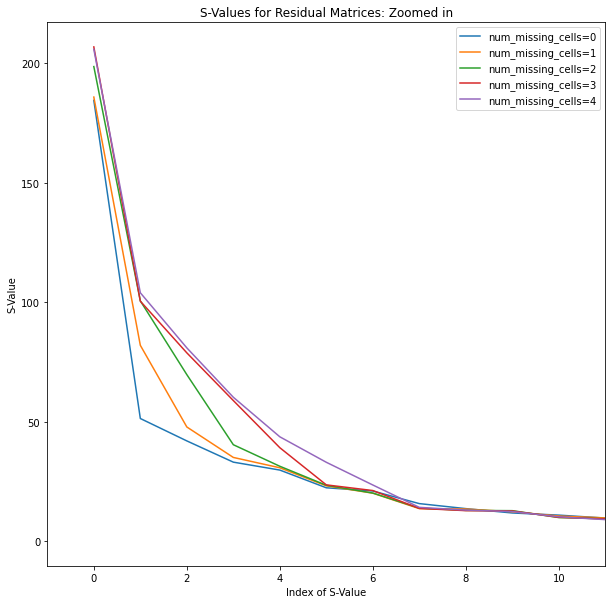

In [32]:
plt.figure(figsize = [10,10])
# Create a color map for differentiating num 
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
for num in num_missing_cells:
    dataframe = s_all[num]
    x = dataframe.index
    y = dataframe.values.flatten()
    color = color_map(num_missing_cells.index(num))
    label = f"num_missing_cells={num}"
    plt.plot(x, y, color=color, label=label)
# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Residual Matrices: Zoomed in')
plt.xlim([-1,num_celltypes + 5])
# Add a legend
plt.legend()
# Display the plot
plt.show()

**Reconstructing Residual Matrix**

In [33]:
#reconstructing SVD using all only some S values, Residual 1.
Recon_Mat_matchS = dict()
for num in num_cells_missing:
    num_SVs = num + 1 #num of comp
    #cutting S and U to 30 to match elbow plots
    U = U_all[num].values[:, :num_SVs]
    S = np.zeros((U.shape[1], Matres_all[num].shape[0]))
    diag_val = s_all[num].values[:num_SVs]
    np.fill_diagonal(S, [diag_val])
    anum = U @ S #reconstructing
    #saving to df dict
    Recon_Mat_matchS[num] = pd.DataFrame(anum[:,0:num_SVs])

**Plotting Correlations between SVD on Residual and Missing Cell Information:**

**Residual** 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


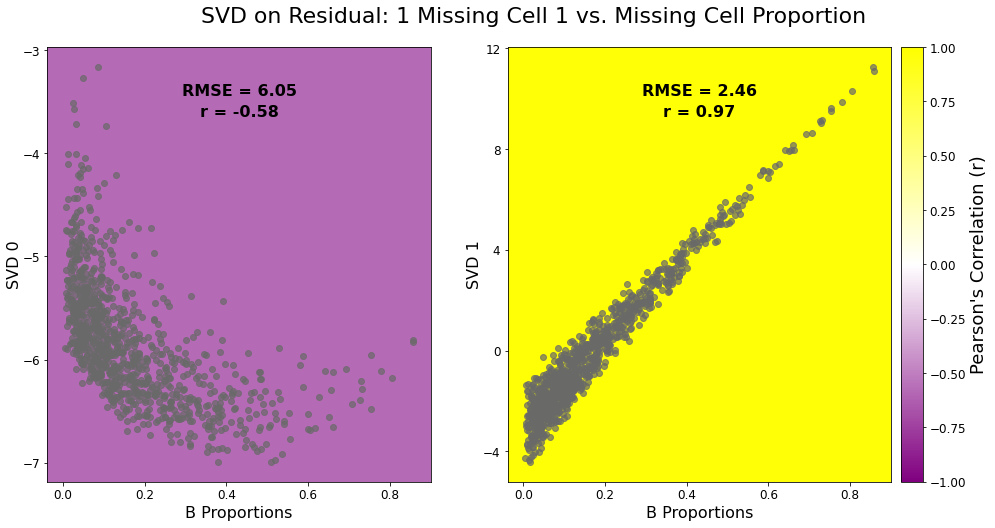

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


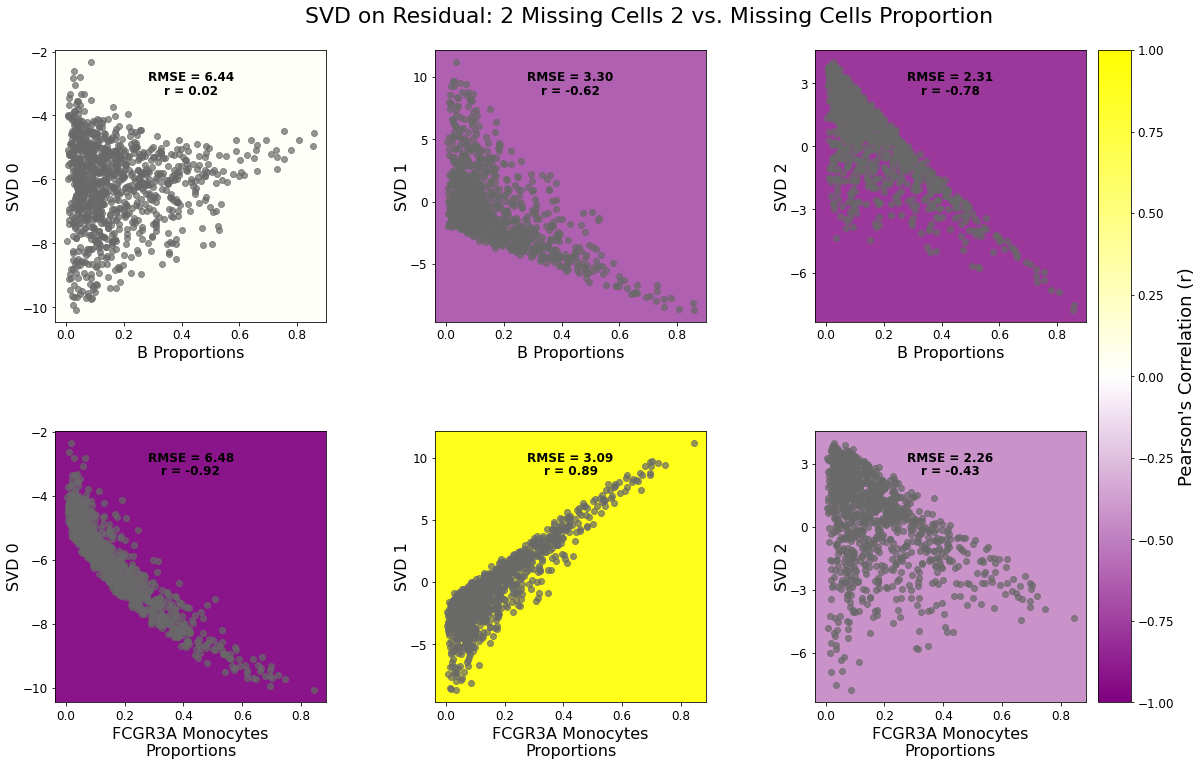

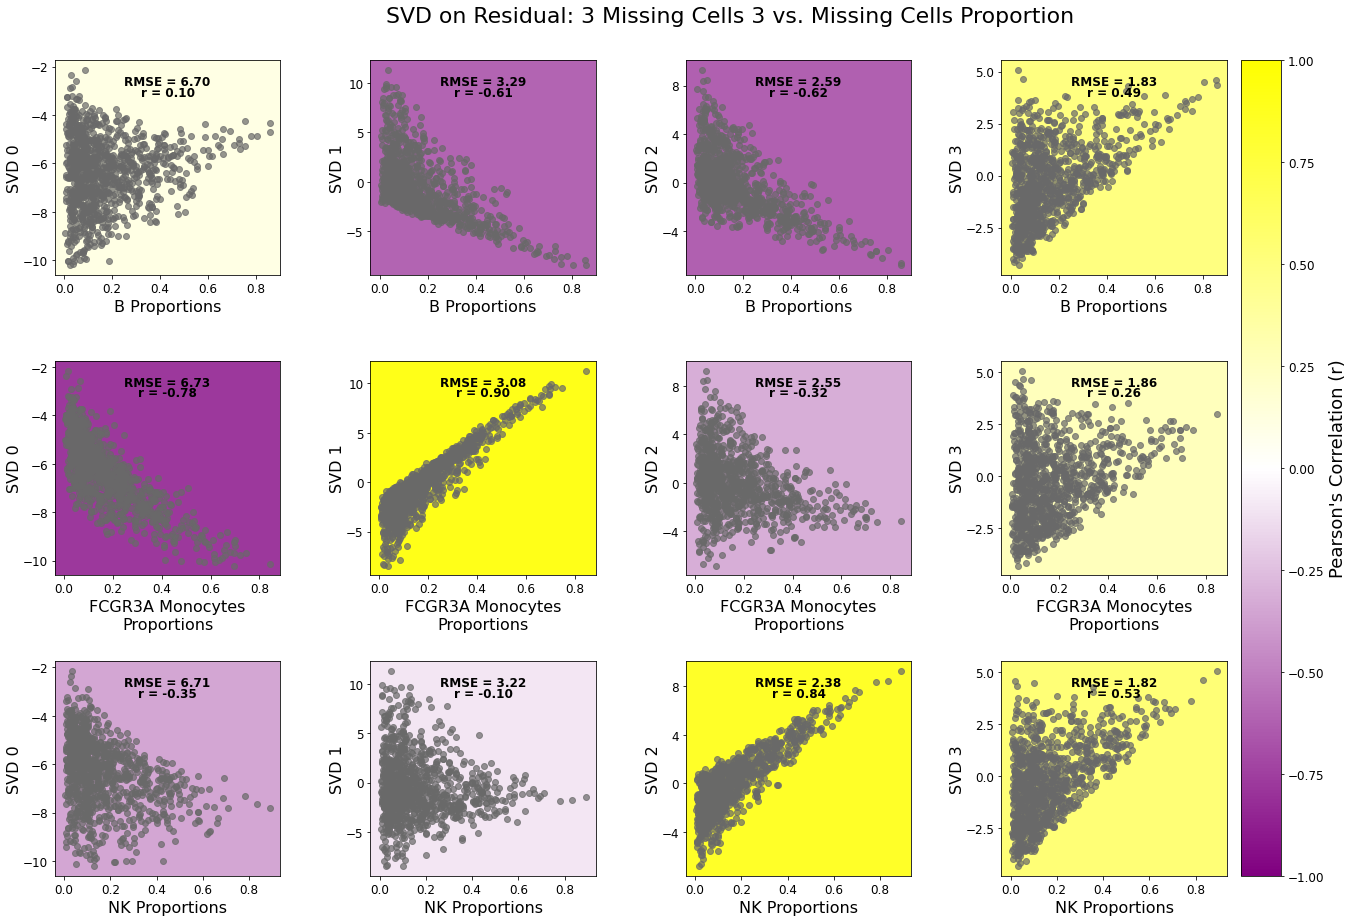

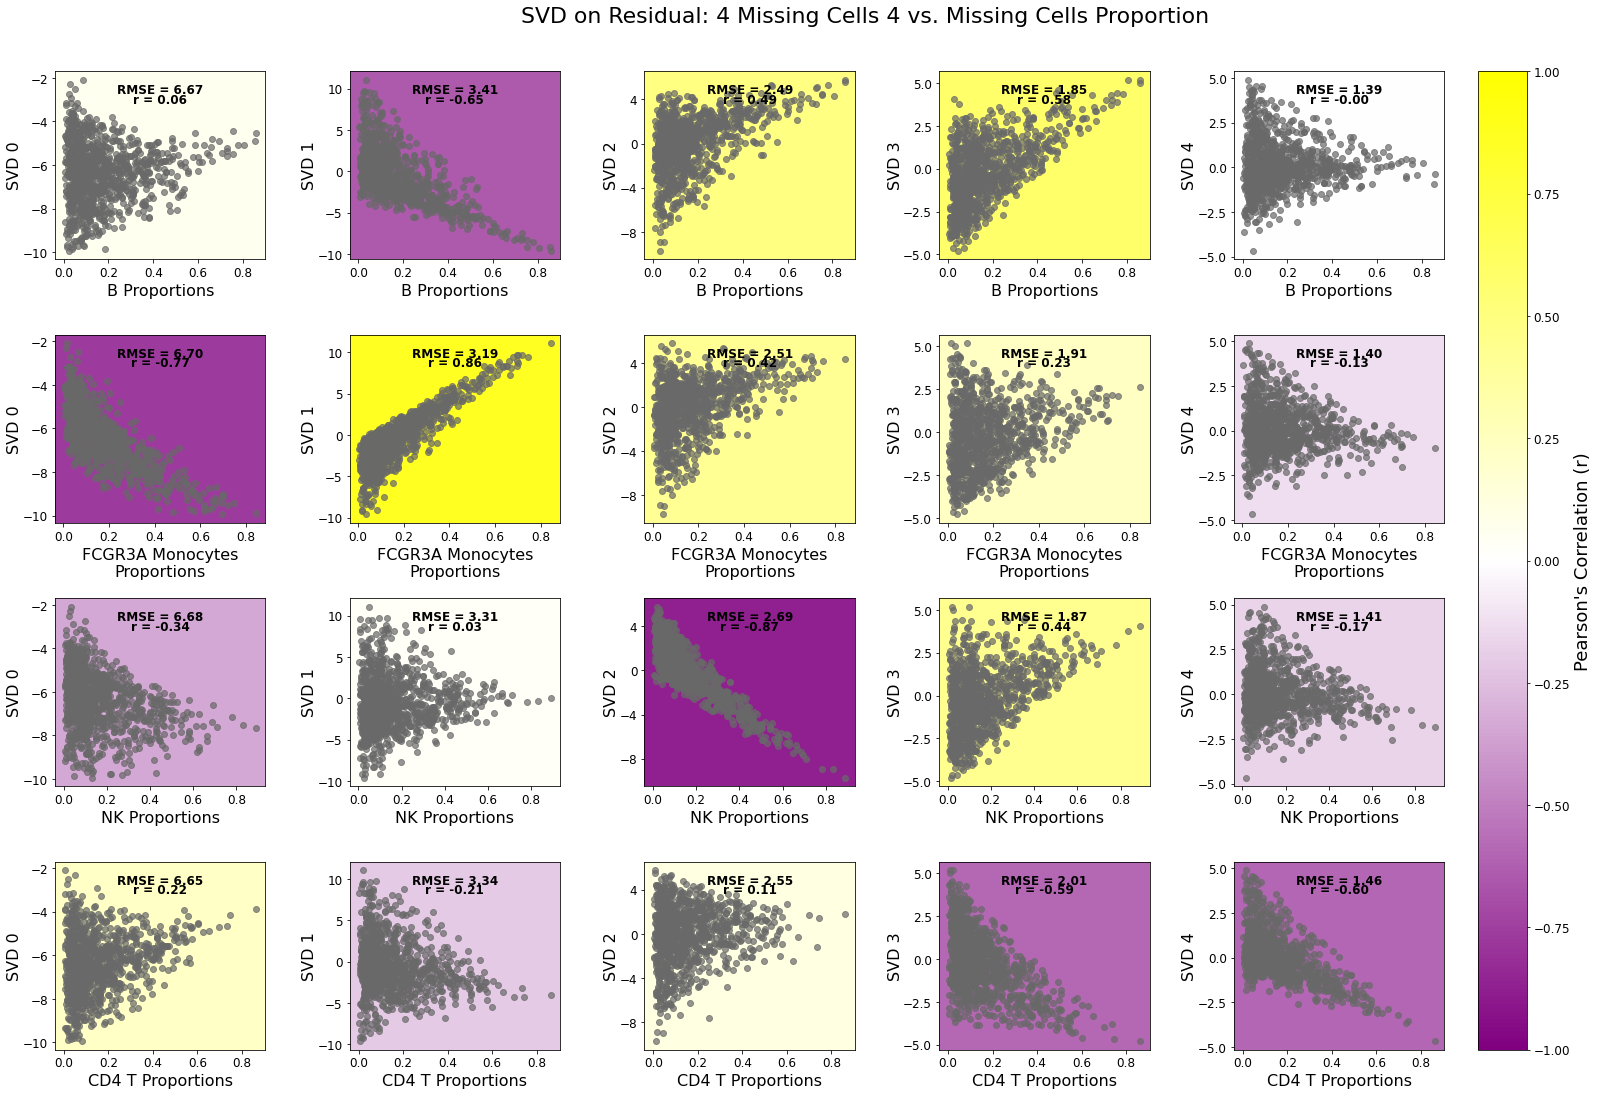

In [34]:
#SVD Residual(by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
vp.factors_vs_proportions_rmse(Recon_Mat_matchS, missing_cell_prop, num_missing_cells, "SVD") 
#Each missing cell's expression * proportion matrix is projected into the SVD's reconstructed matrix (just S * U).        

## **PCA**

Calculating PCA for each Residual and Percent of Variance Explained

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


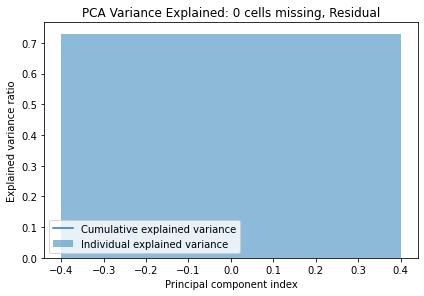

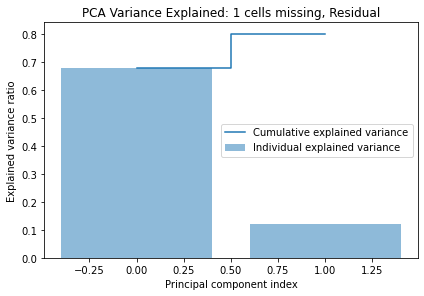

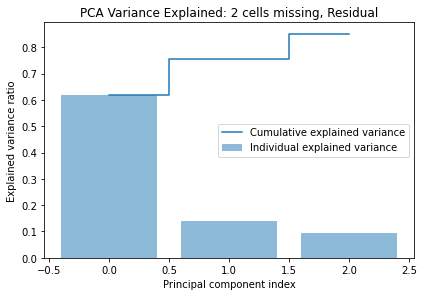

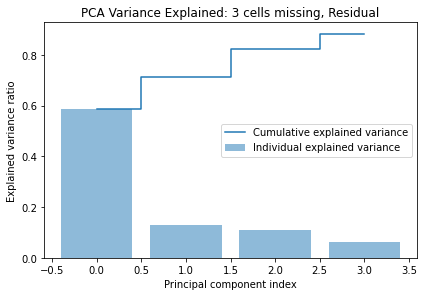

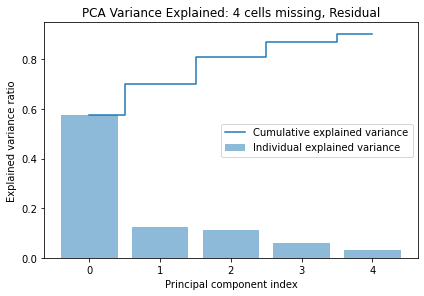

In [35]:
pca_res = dict()
for num in num_cells_missing:
    df = residuals[num].T #transposing to get length of genes instead of samples
    fit = PCA(n_components= num + 1)
    pca_results = fit.fit_transform(df.values)

    exp_var_pca = fit.explained_variance_ratio_
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)

    ## plot variance explained
    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.title(f"PCA Variance Explained: {num} cells missing, Residual")
    plt.show()
    pca_res[num] = pd.DataFrame(pca_results)

Analyzing PCA Results

Residual

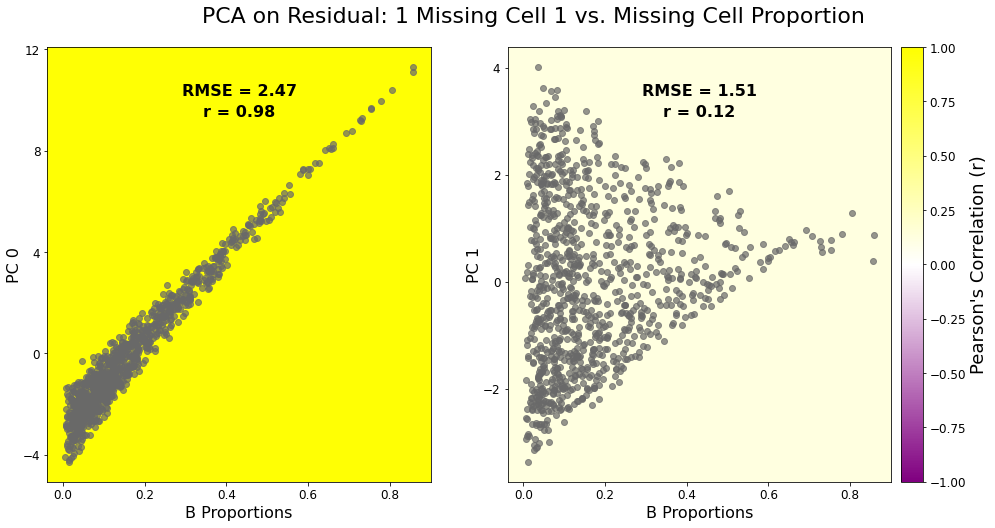

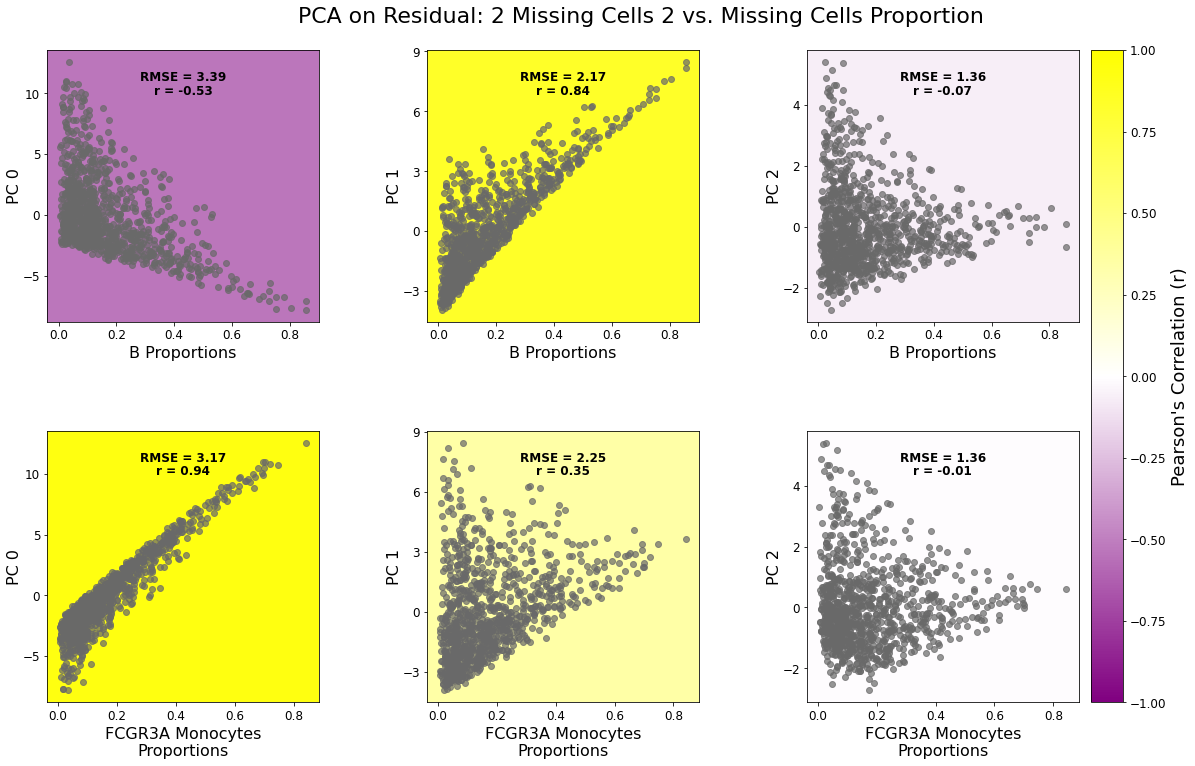

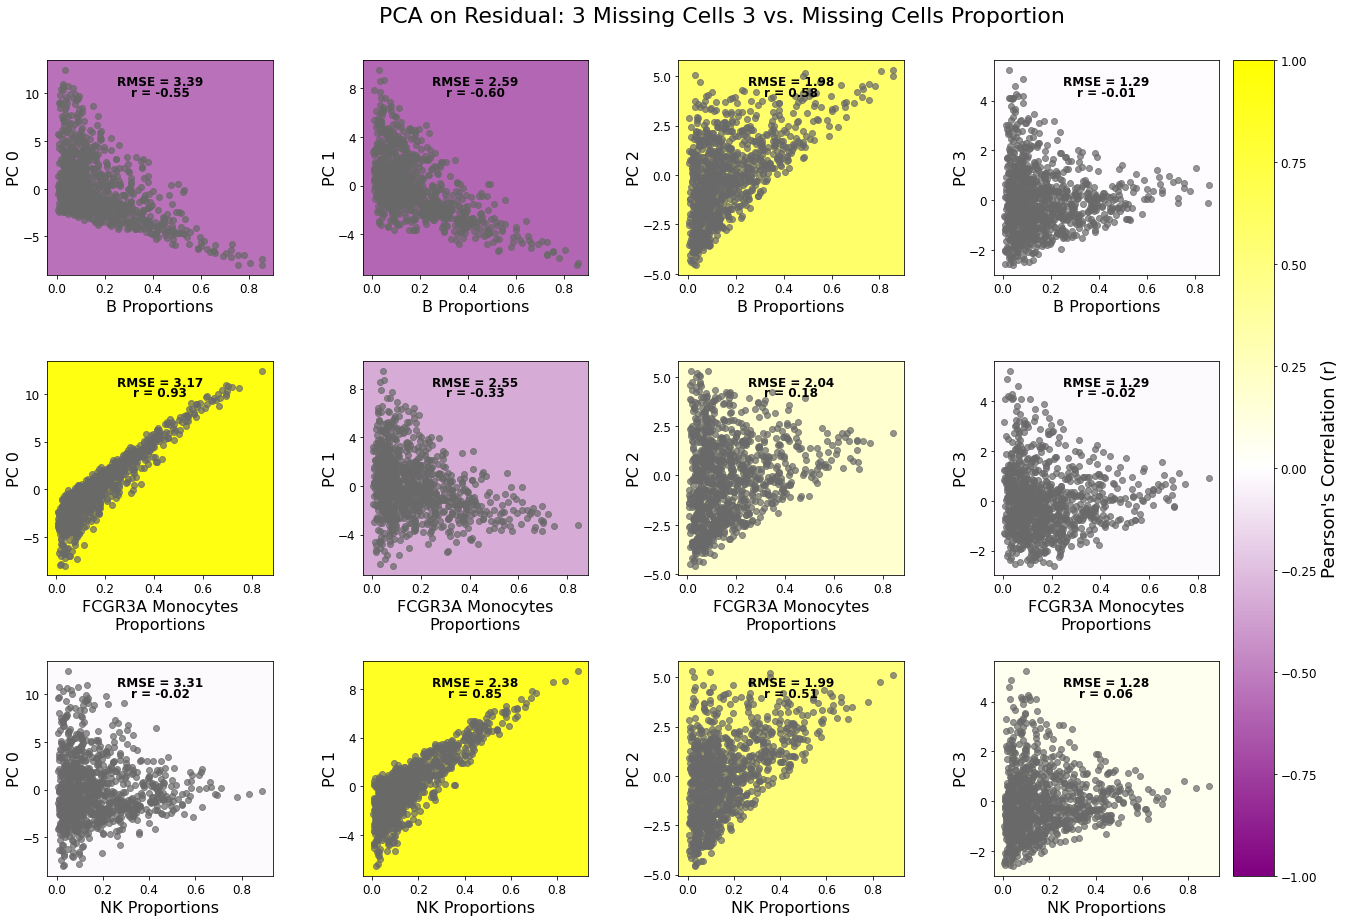

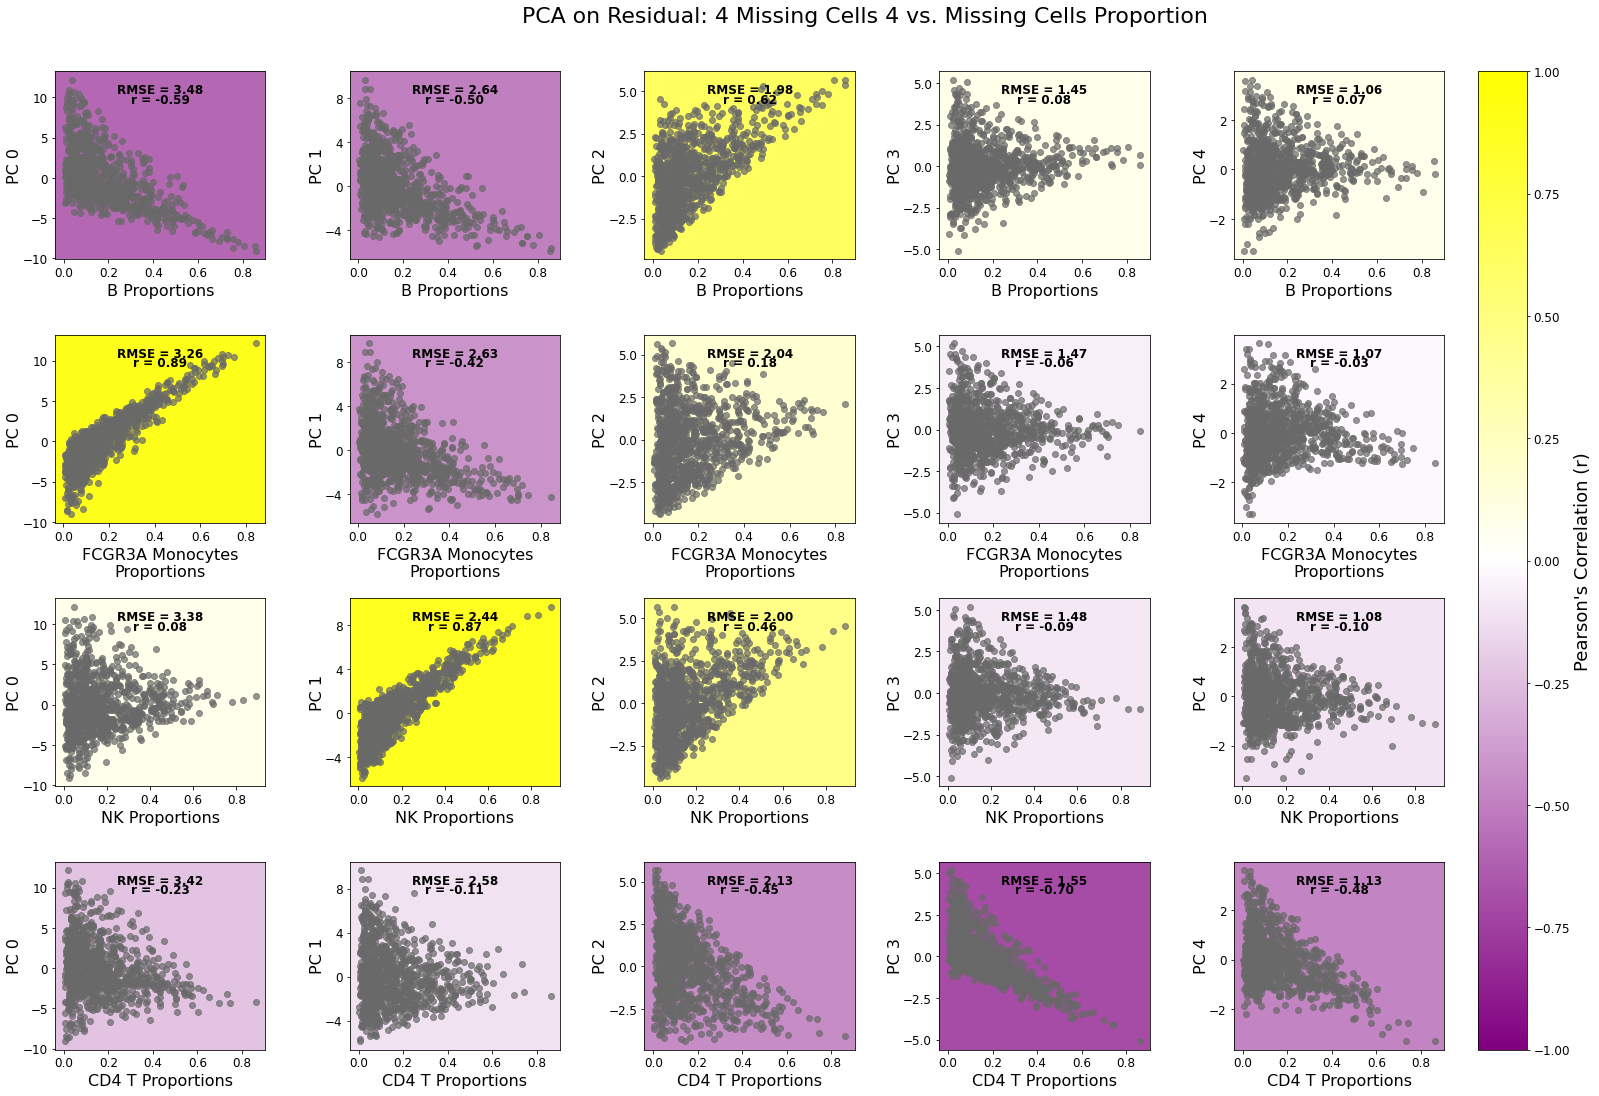

In [36]:
#PCA Residual(by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
res_pca_sample = dict()
for num in num_missing_cells[1:]:
    num_pca = num + 1
    pca = PCA(n_components = num_pca)
    res_pca_df = pca.fit_transform(residuals[num])
    res_pca_sample[num] = pd.DataFrame(res_pca_df)#each missing cell type expression with each Component
vp.factors_vs_proportions_rmse(res_pca_sample, missing_cell_prop, num_cells_missing, "PCA")

## **ICA**

Calculate ICA

In [37]:
#ICA on residual 1
res_ica = dict()
for num in num_missing_cells:
    num_ica = num + 1
    ica = FastICA(n_components = num_ica)
    res_ica_df = ica.fit_transform(residuals[num].T)
    res_ica_df = pd.DataFrame(res_ica_df)
    res_ica[num] = res_ica_df

Residual

/projects/aivich@xsede.org/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/projects/aivich@xsede.org/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/projects/aivich@xsede.org/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


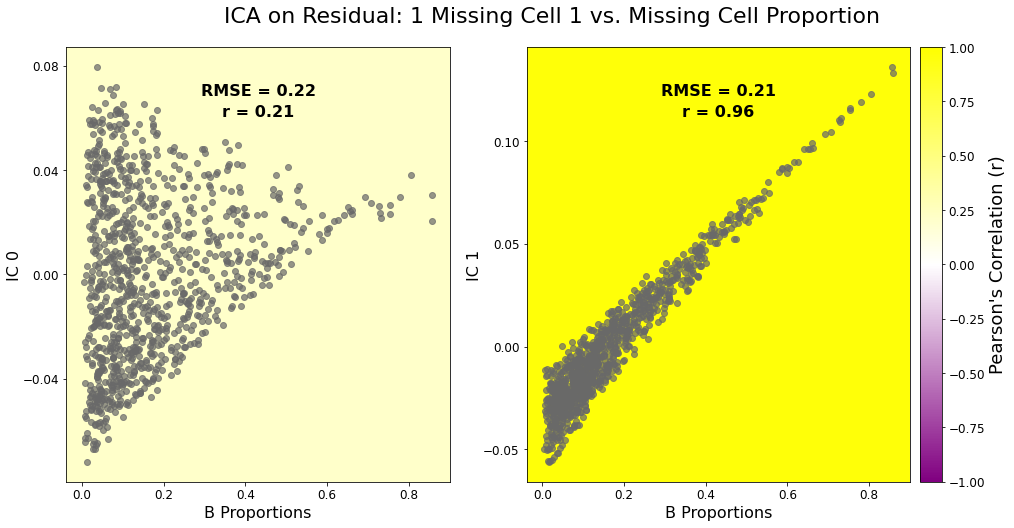

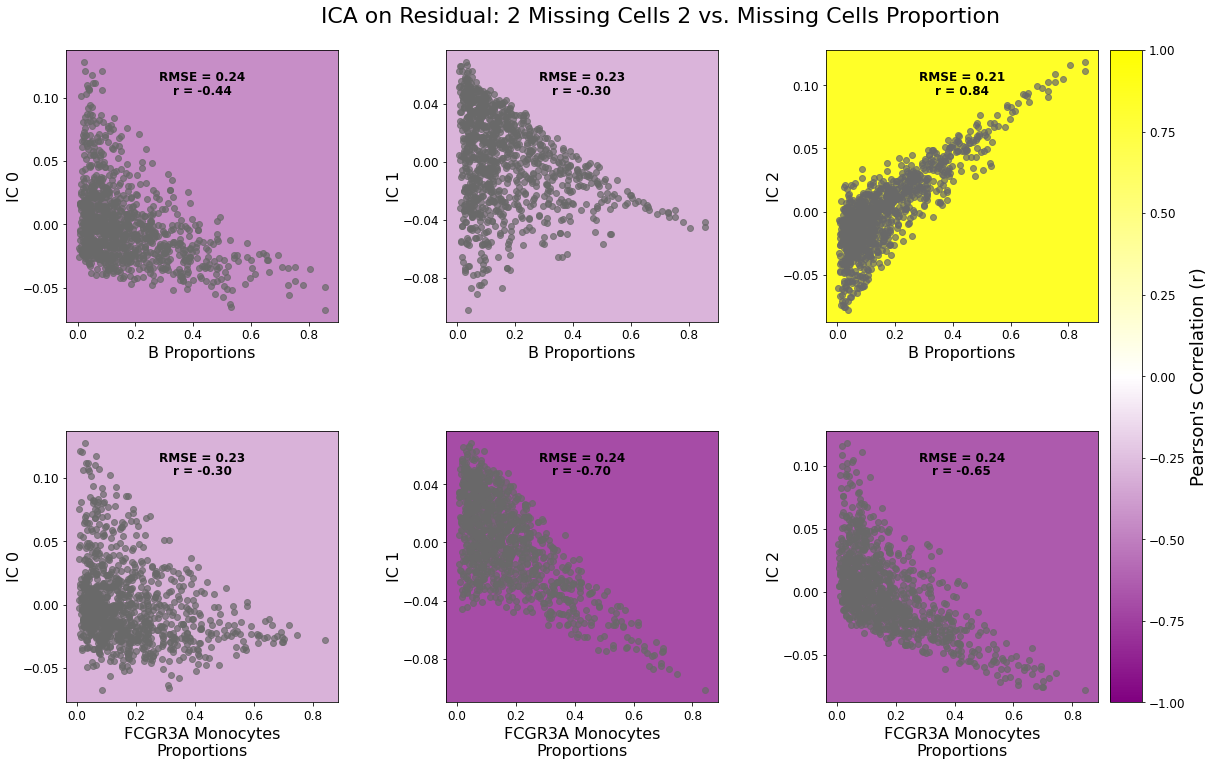

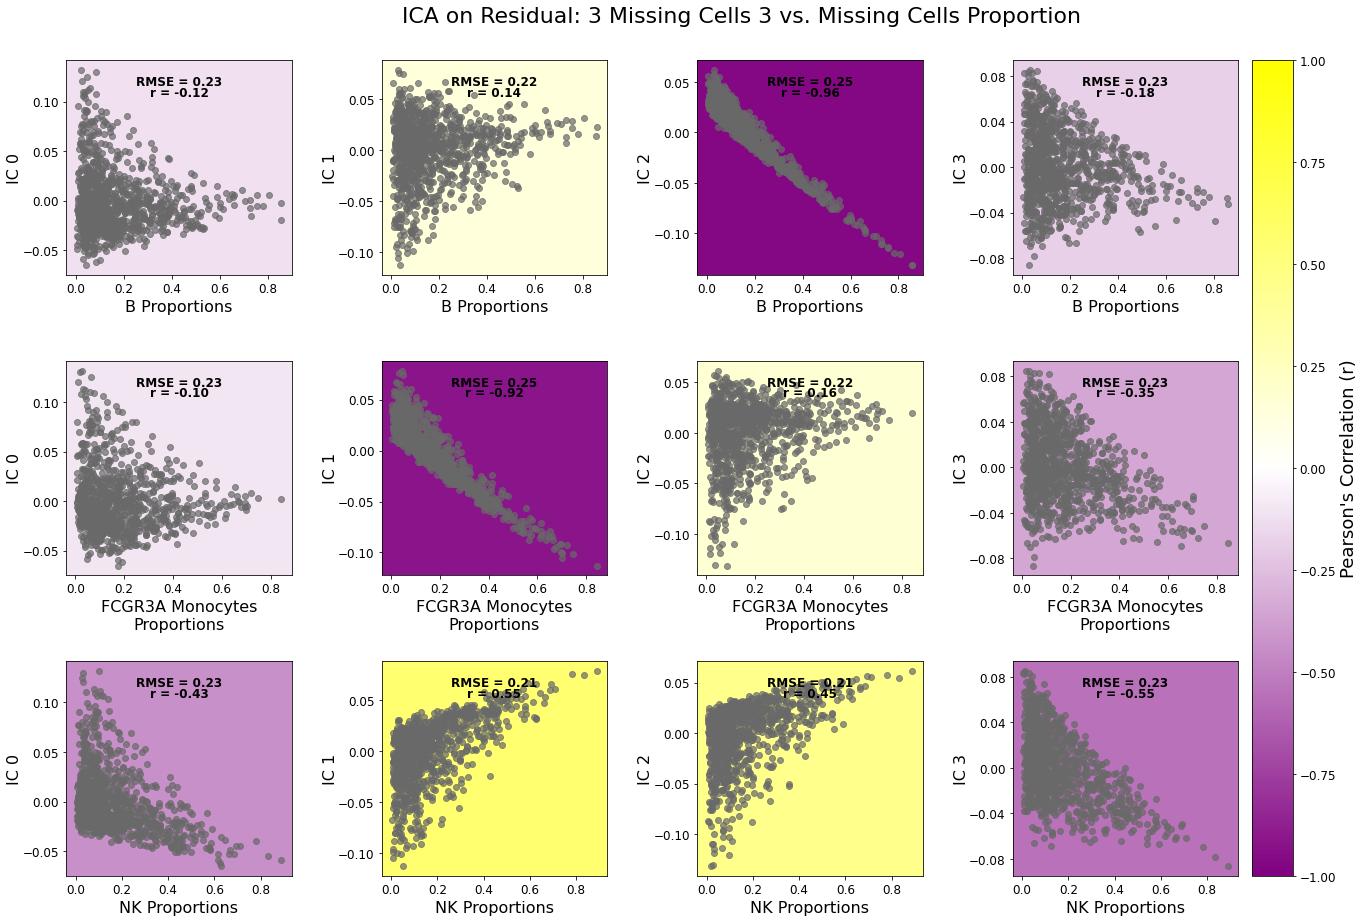

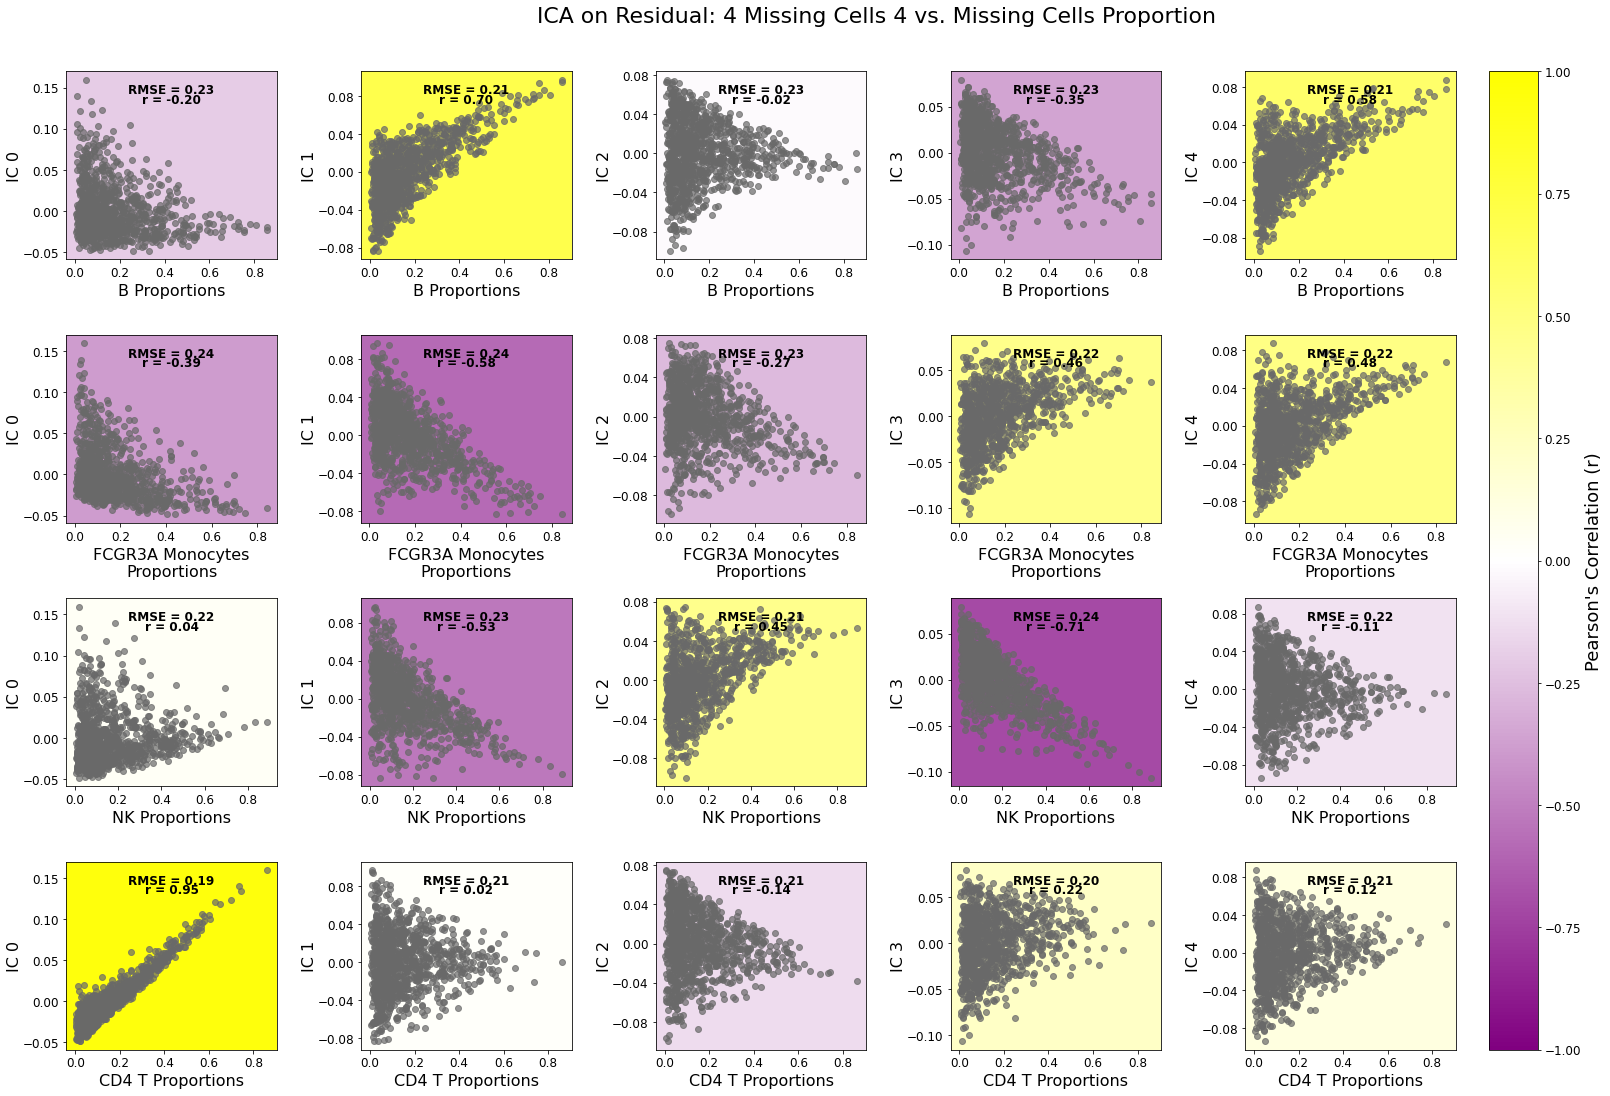

In [38]:
#ICA Residual (by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
res_ICA_sample = dict()
for num in num_missing_cells[1:]:
    num_ICA = num + 1
    ica = FastICA(n_components = num_ICA)
    res_ICA_df = ica.fit_transform(residuals[num])
    res_ICA_sample[num] = pd.DataFrame(res_ICA_df)#each missing cell type expression with each Component
vp.factors_vs_proportions_rmse(res_ICA_sample, missing_cell_prop, num_cells_missing, "ICA")

## NMF

Analyzing how close to negative the distributions of each residual are:

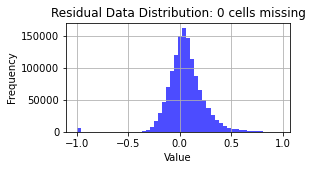

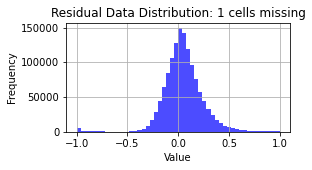

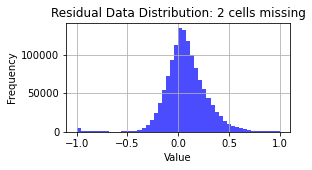

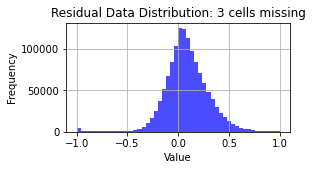

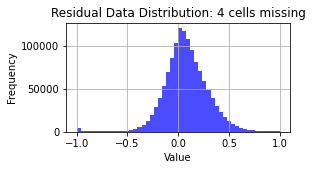

In [39]:
#distribution of residuals
for num in num_missing_cells:
    data = residuals[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Shifting distributions according to above plots, and calculating NMF:

1.0000000000000002


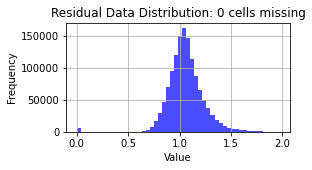

1.0000000000000002


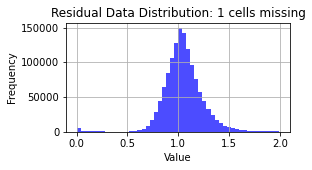

1.0000000000000002


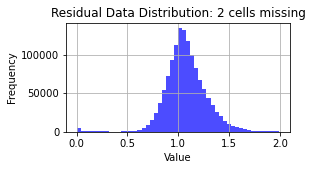

1.0000000000000002


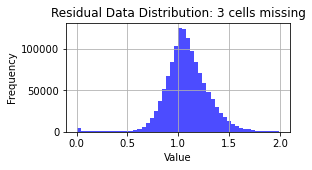

1.0000000000000002


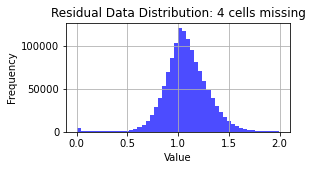

In [40]:
#shifting distribution of residuals to do NMF
residuals_shift = residuals
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift distributions minimally:
        min_val = abs(np.min(np.min(residuals[num])))
        print(min_val)
        residuals_shift[num] = residuals[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift[num][residuals_shift[num].values <= 0] = 0
    data = residuals_shift[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.xlim(data.min()-.1, data.max()+.1)
    plt.show()

### Analyzing NMF Results:

Now comparing the Residual Scaled (with pseudobulks and reference MinMax scaled) and the Residual (not scaled, all matrices as used in deconvolution). We can see the impact of scaling in our ability to recover the missing cell type's proportions.

Residual

/projects/aivich@xsede.org/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(
/projects/aivich@xsede.org/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


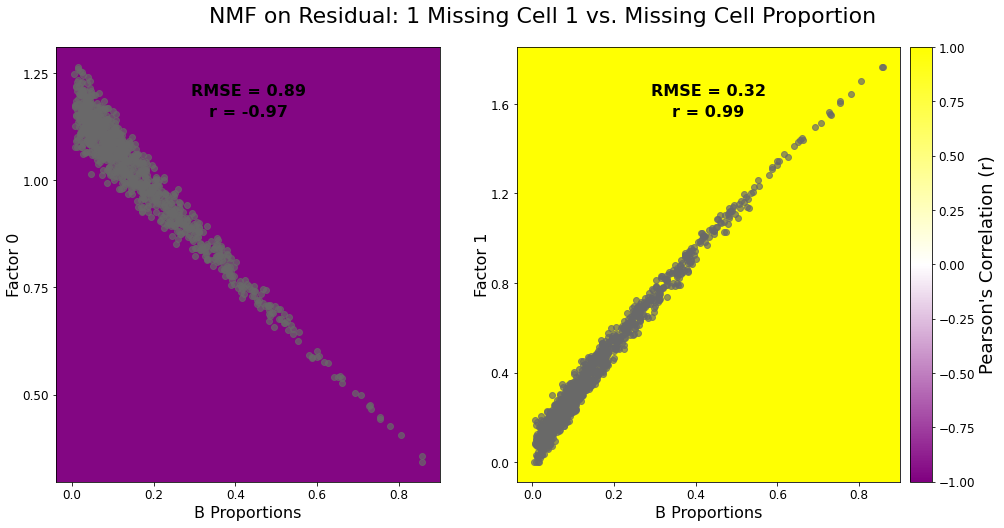

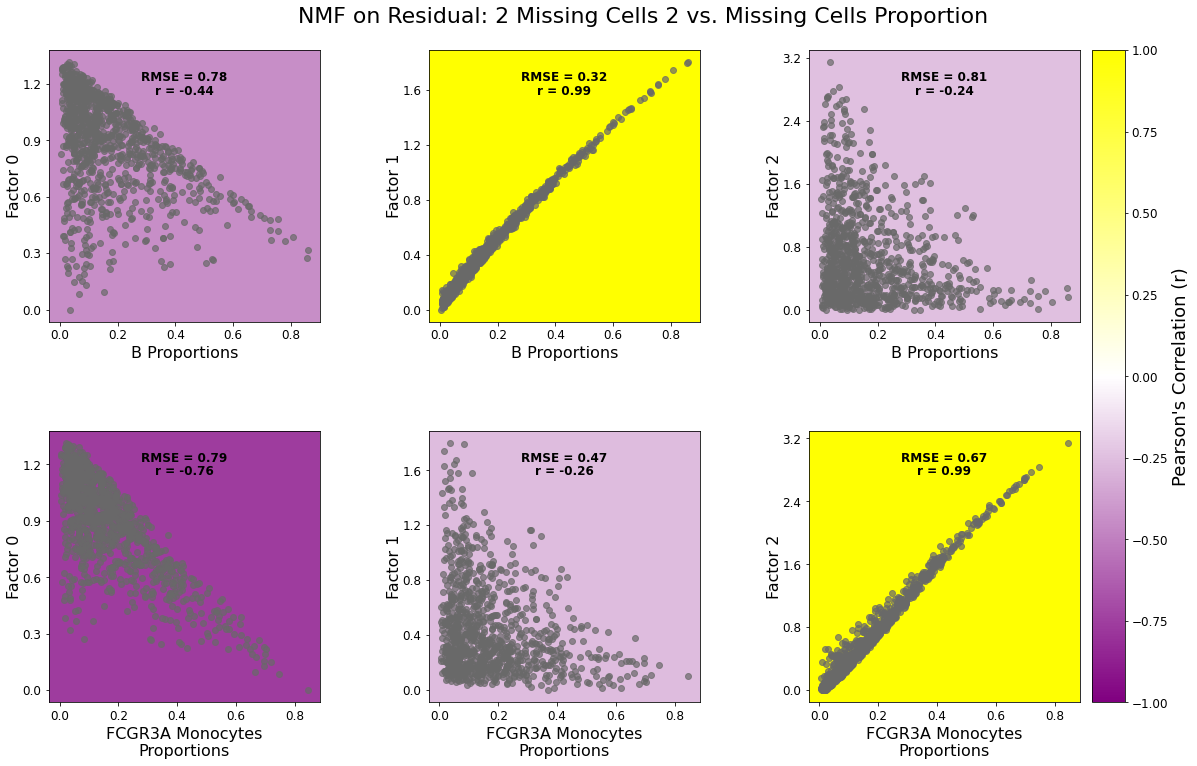

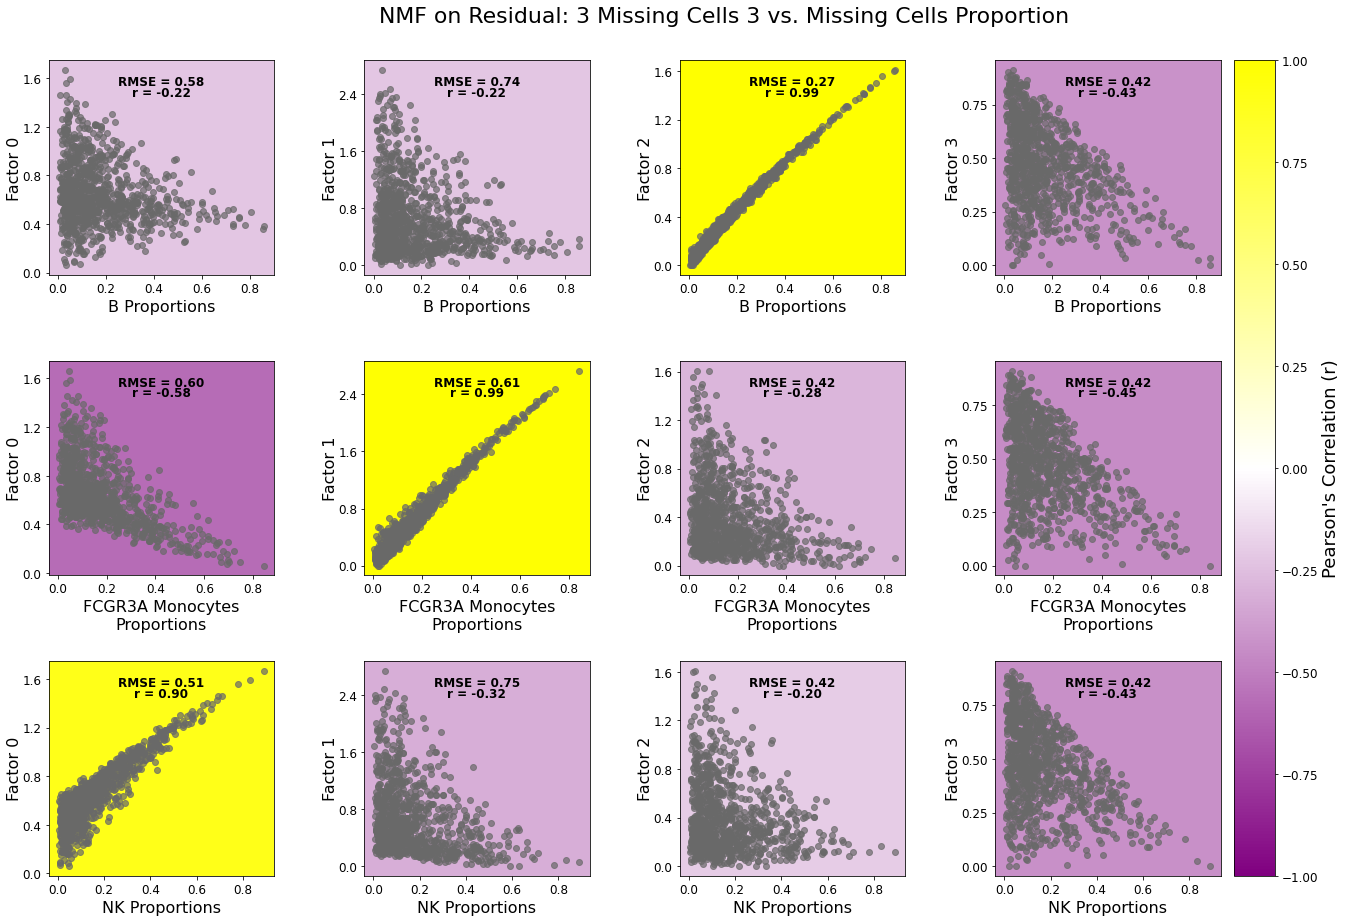

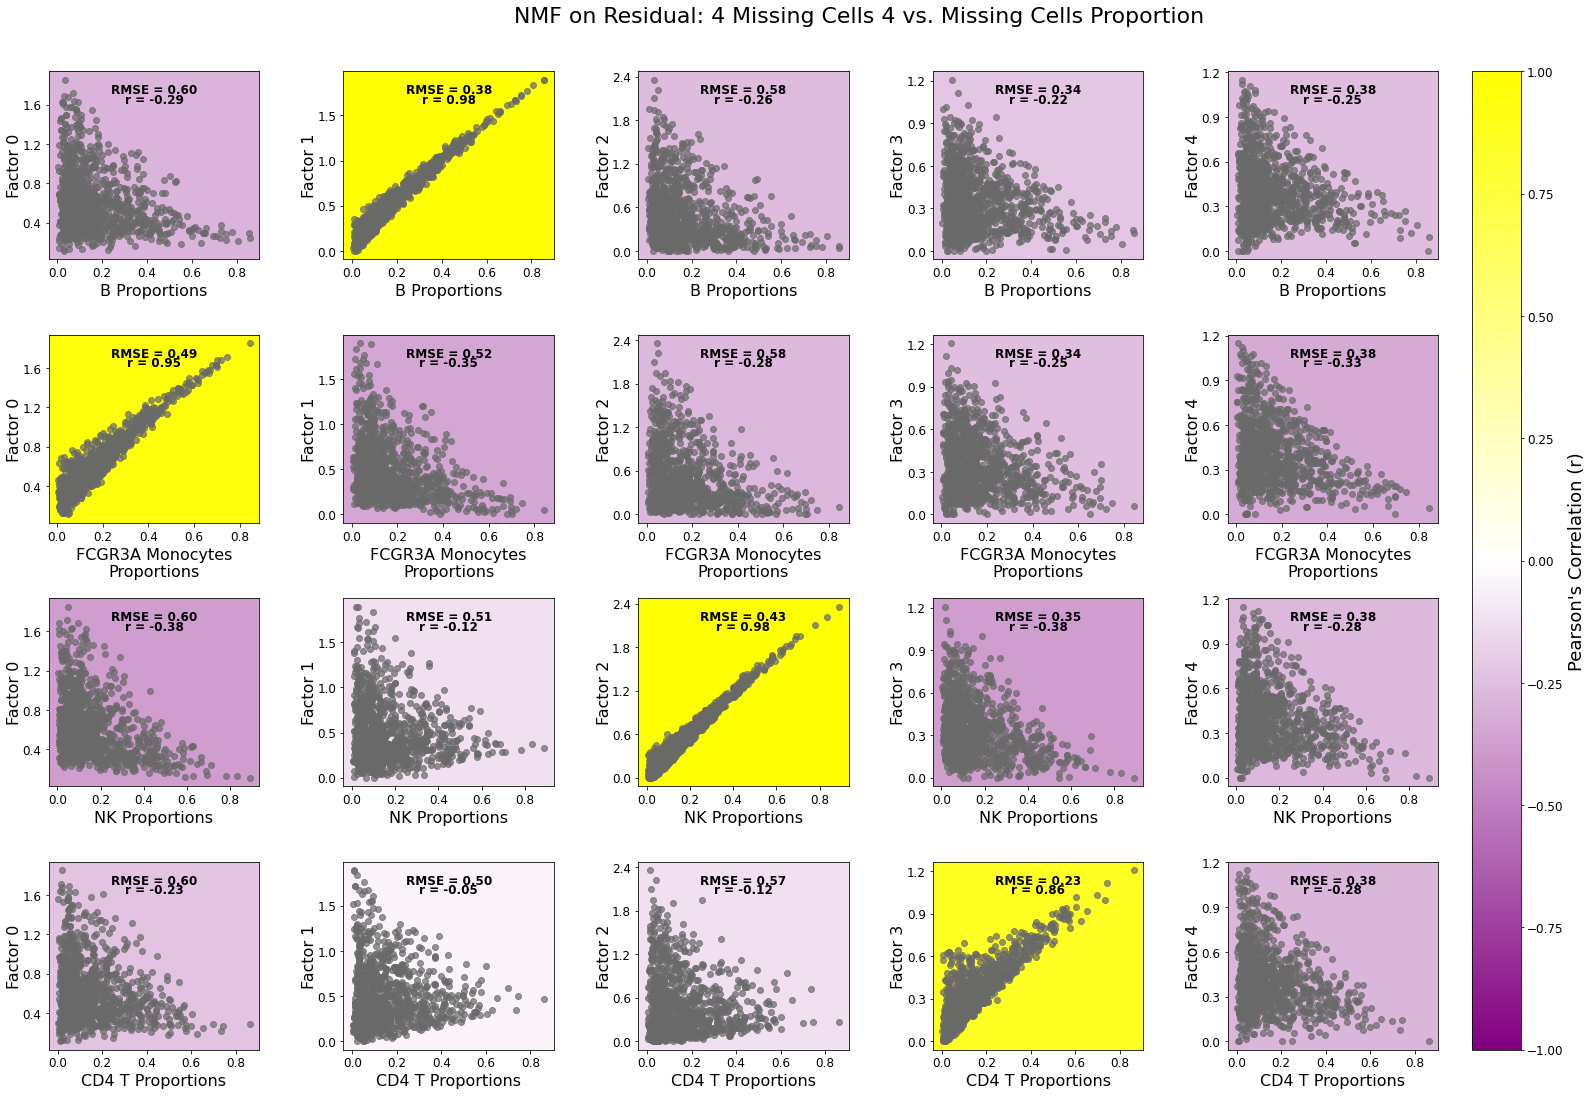

In [41]:
#NMF Residual(by sample) compared to each missing celltype proportion
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf, max_iter = 10000, init='nndsvd')
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_rmse(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 

Same as above, but now making the NMF components be in the same scale (0 to 1).

/projects/aivich@xsede.org/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(
/projects/aivich@xsede.org/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


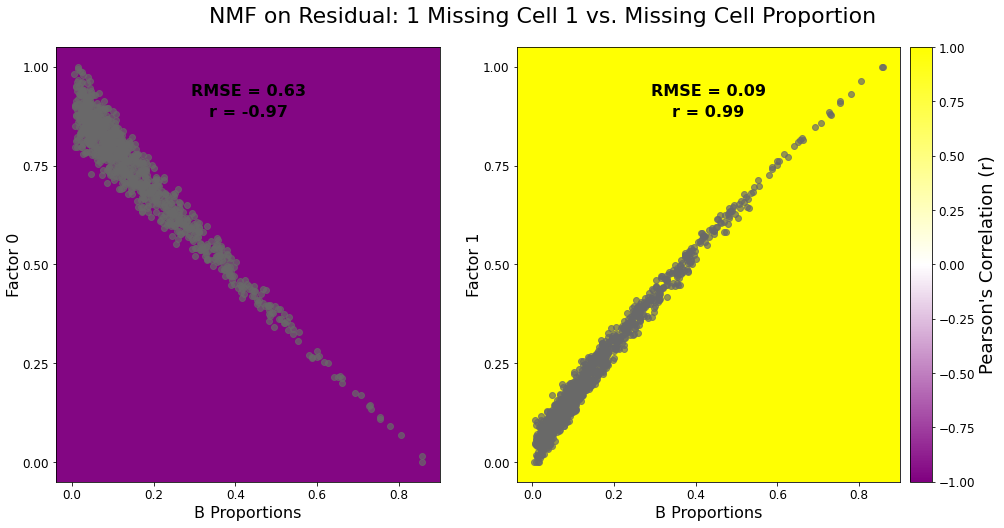

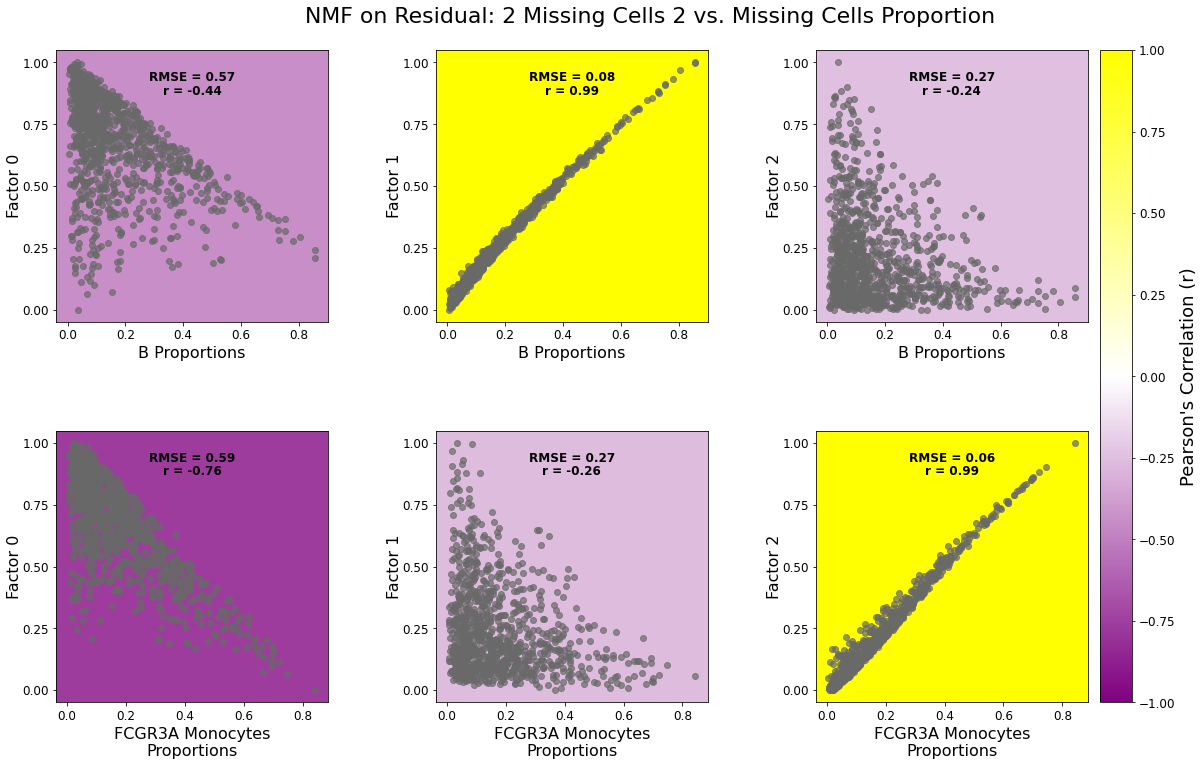

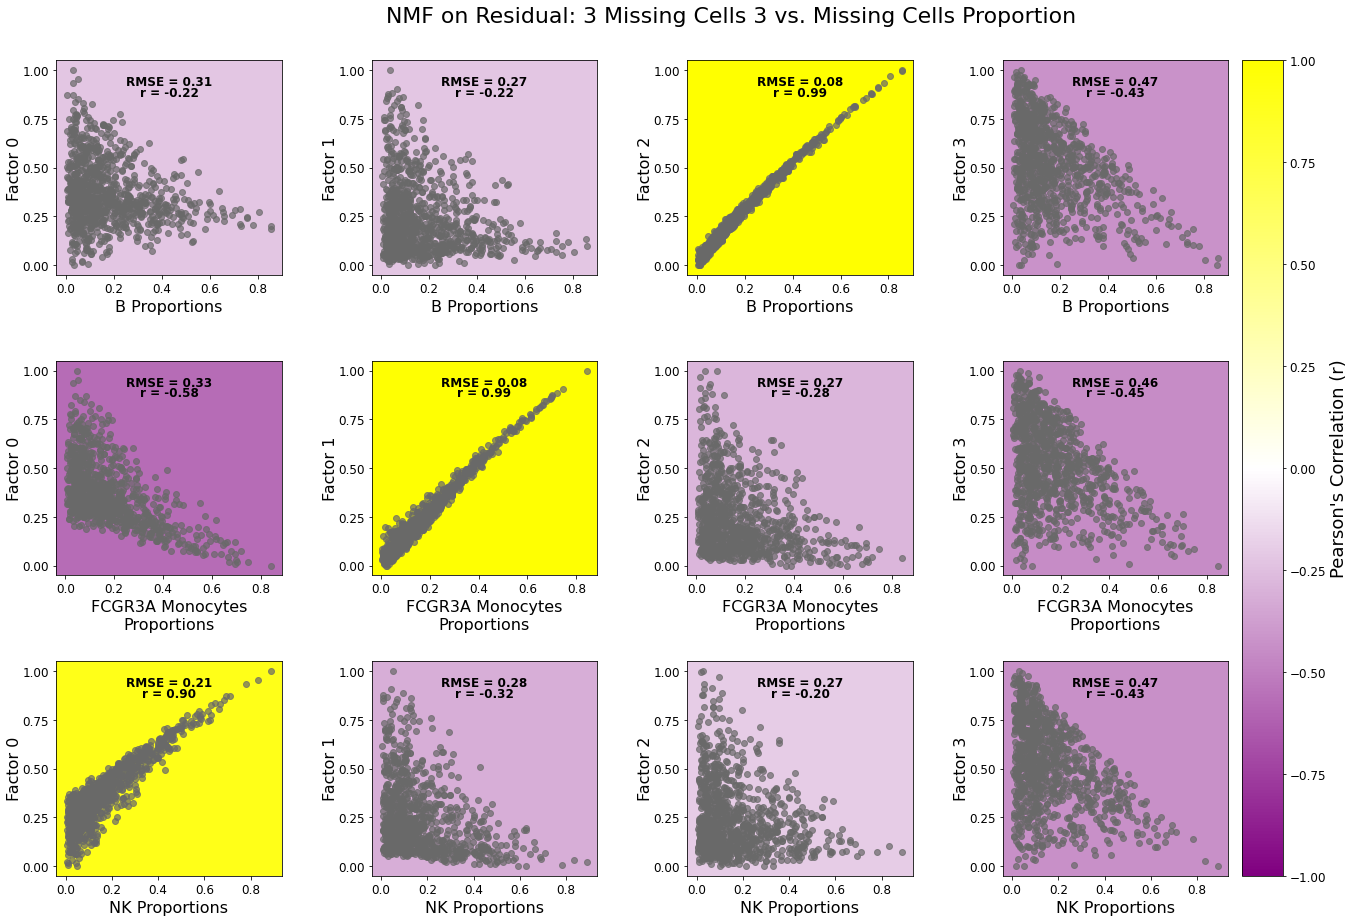

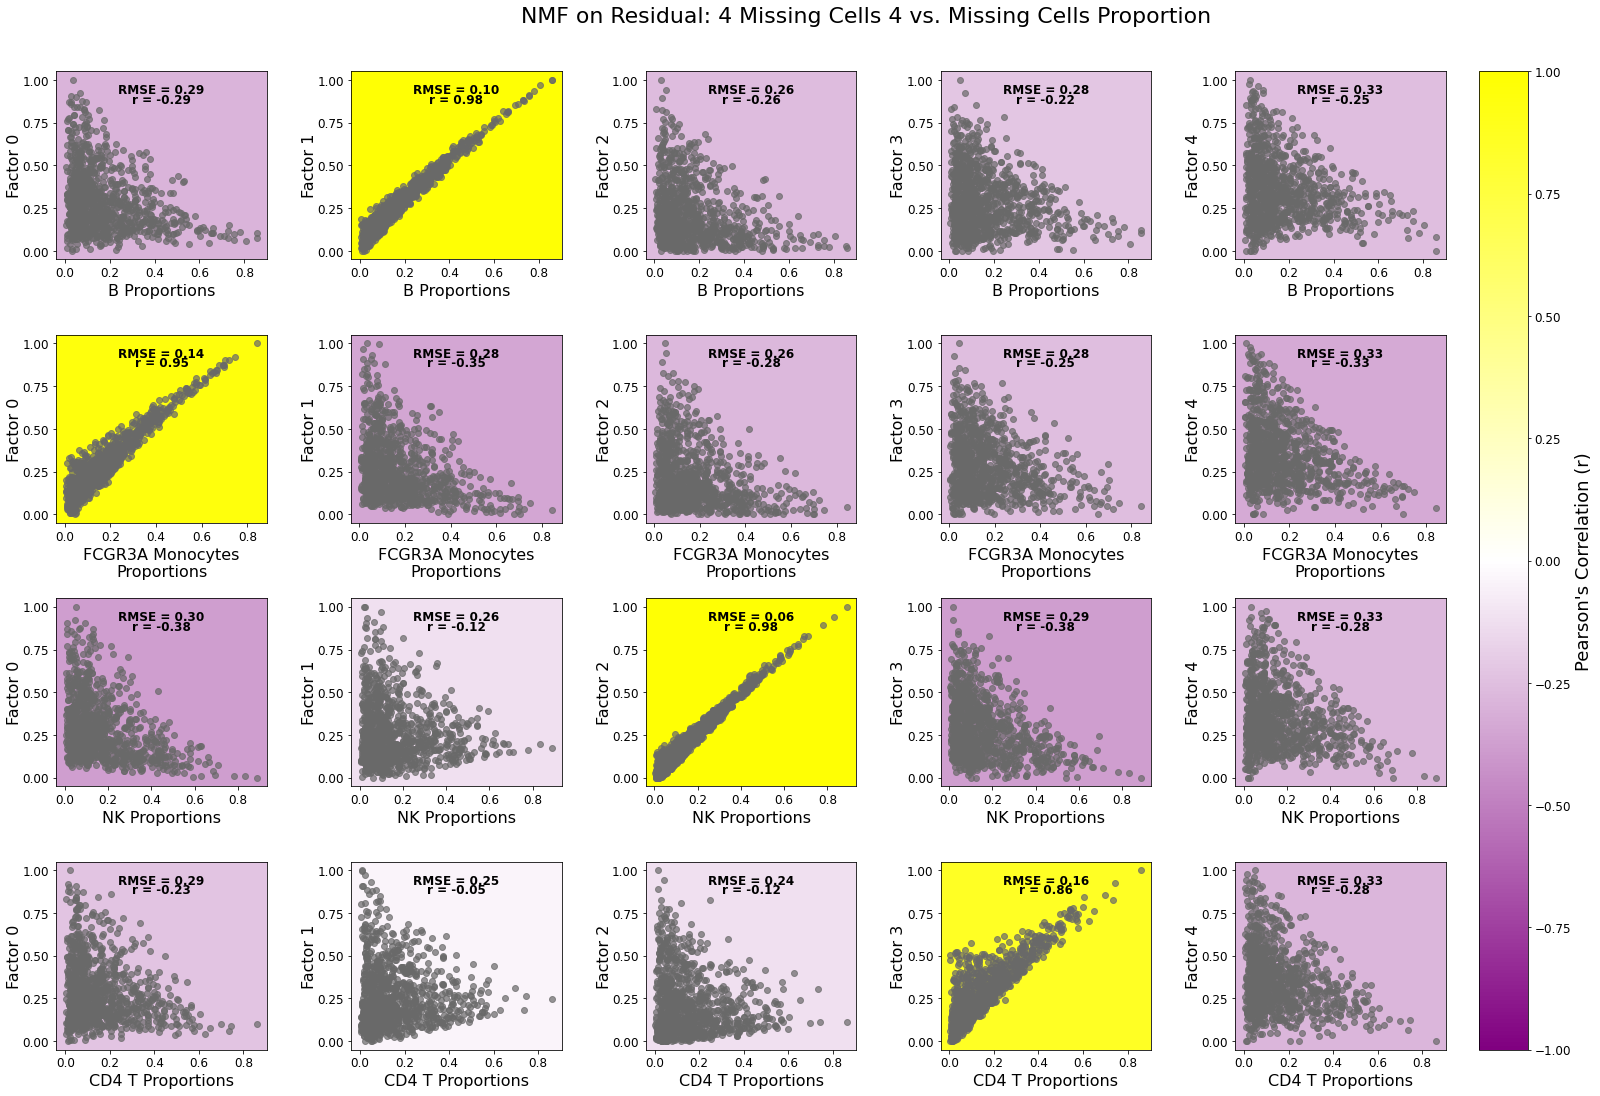

In [42]:
#NMF Residual(by sample) compared to each missing celltype proportion
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf, max_iter = 10000 ,init='nndsvd')
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
    #putting each component between 0 and 1 to match proportion range
    pseudo_raw_val = res_nmf_df.values 
    scaler = MinMaxScaler()
    scaler.fit(pseudo_raw_val)
    pseudo_scale = scaler.transform(pseudo_raw_val)
    res_nmf[num] = pd.DataFrame(pseudo_scale)
vp.factors_vs_proportions_rmse(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 

Analyzing and Comparing other Deconvolution Methods:

In [43]:
# Define filenames
real_filename_nnls = f"{path_results}EXP2_NNLS_pbmc_real.txt"
predicted_filename_nnls = f"{path_results}EXP2_NNLS_pbmc_predicted.txt"
real_filename_bp = f"{path_results}EXP2_bayesprism_pbmc_real.txt"
predicted_filename_bp = f"{path_results}EXP2_bayesprism_pbmc_predicted.txt"
real_filename_cs = f"{path_results}EXP2_cibersortx_pbmc_real.txt"
predicted_filename_cs = f"{path_results}EXP2_cibersortx_pbmc_predicted.txt"


# Read data into dataframes
real_df_nnls = pd.read_csv(real_filename_nnls, sep='\t', index_col=0)
predicted_df_nnls = pd.read_csv(predicted_filename_nnls, sep='\t', index_col=0)
real_df_bp = pd.read_csv(real_filename_bp, sep='\t', index_col=0)
predicted_df_bp = pd.read_csv(predicted_filename_bp, sep='\t', index_col=0)
real_df_cs = pd.read_csv(real_filename_cs, sep='\t', index_col=0)
predicted_df_cs = pd.read_csv(predicted_filename_cs, sep='\t', index_col=0)


In [44]:
real_df_nnls["num"] = real_df_nnls.index
predicted_df_nnls["num"] = predicted_df_nnls.index

real_df_bp["num"] = real_df_bp.index
predicted_df_bp["num"] = predicted_df_bp.index

real_df_cs["num"] = real_df_cs.index
predicted_df_cs["num"] = predicted_df_cs.index

real_df_nnls.index = range(0,5000)
predicted_df_nnls.index = range(0,5000)

real_df_bp.index= range(0,5000)
predicted_df_bp.index= range(0,5000)

real_df_cs.index= range(0,5000)
predicted_df_cs.index= range(0,5000)

QC

In [45]:
# Function to calculate RMSE ignoring NaN values
def calculate_rmse(row_real, row_predicted):
    nan_mask = ~np.isnan(row_real)
    return vp.rmse(row_real[nan_mask], row_predicted[nan_mask])

In [46]:
# Iterate through each num_missing_cells
rmse_nnls = pd.DataFrame()
for num in real_df_nnls["num"].unique():
    rmse_vals = []
    real = pd.DataFrame(real_df_nnls[real_df_nnls["num"] == num])
    pred = pd.DataFrame(predicted_df_nnls[predicted_df_nnls["num"] == num])
    # Iterate through each row (sample)
    for idx in range(len(real)):
        rmse_current = calculate_rmse(real.iloc[idx], pred.iloc[idx])
        rmse_vals.append(rmse_current)
    rmse_nnls = pd.concat([rmse_nnls, pd.DataFrame(rmse_vals)], ignore_index=True)
rmse_nnls


0
0     0.100203
1     0.058129
2     0.075433
3     0.061432
4     0.087006
...        ...
4995  0.276294
4996  0.353835
4997  0.285131
4998  0.362485
4999  0.296724

[5000 rows x 1 columns]

In [47]:
# Iterate through each num_missing_cells
rmse_nnls = pd.DataFrame()
for num in real_df_nnls["num"].unique():
    rmse_vals = []
    real = pd.DataFrame(real_df_nnls[real_df_nnls["num"] == num])
    pred = pd.DataFrame(predicted_df_nnls[predicted_df_nnls["num"] == num])
    # Iterate through each row (sample)
    for idx in range(len(real)):
        rmse_current = calculate_rmse(real.iloc[idx], pred.iloc[idx])
        rmse_vals.append(rmse_current)
    rmse_nnls = pd.concat([rmse_nnls, pd.DataFrame(rmse_vals, columns=['NNLS'])], ignore_index=True)

# Iterate through each num_missing_cells for bayesprism
rmse_bayesprism = pd.DataFrame()
for num in real_df_bp["num"].unique():
    rmse_vals = []
    real = pd.DataFrame(real_df_bp[real_df_bp["num"] == num])
    pred = pd.DataFrame(predicted_df_bp[predicted_df_bp["num"] == num])
    for idx in range(len(real)):
        rmse_current = calculate_rmse(real.iloc[idx], pred.iloc[idx])
        rmse_vals.append(rmse_current)
    rmse_bayesprism = pd.concat([rmse_bayesprism, pd.DataFrame(rmse_vals, columns=['BayesPrism'])], ignore_index=True)

# Iterate through each num_missing_cells for cibersortx
rmse_cibersortx = pd.DataFrame()
for num in real_df_cs["num"].unique():
    rmse_vals = []
    real = pd.DataFrame(real_df_cs[real_df_cs["num"] == num])
    pred = pd.DataFrame(predicted_df_cs[predicted_df_cs["num"] == num])
    for idx in range(len(real)):
        rmse_current = calculate_rmse(real.iloc[idx], pred.iloc[idx])
        rmse_vals.append(rmse_current)
    rmse_cibersortx = pd.concat([rmse_cibersortx, pd.DataFrame(rmse_vals, columns=['CIBERSORTx'])], ignore_index=True)

# Combine all RMSE DataFrames into one
all_rmse = pd.concat([rmse_nnls, rmse_bayesprism, rmse_cibersortx], axis=1)

# Add a new column "num" to the all_rmse DataFrame
all_rmse['num'] = np.repeat(num_missing_cells, 1000)
all_rmse

NNLS  BayesPrism  CIBERSORTx  num
0     0.100203    0.031963    0.048839    0
1     0.058129    0.040702    0.051600    0
2     0.075433    0.033075    0.047308    0
3     0.061432    0.035098    0.047167    0
4     0.087006    0.028018    0.039989    0
...        ...         ...         ...  ...
4995  0.276294    0.254718    0.255461    4
4996  0.353835    0.368503    0.360872    4
4997  0.285131    0.281348    0.318716    4
4998  0.362485    0.372383    0.175987    4
4999  0.296724    0.310484    0.281892    4

[5000 rows x 4 columns]

/projects/aivich@xsede.org/code-server/tmp/ipykernel_1660688/4205476270.py:25: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  violin.set_xticklabels(violin.get_xticklabels(), font_properties)
/projects/aivich@xsede.org/code-server/tmp/ipykernel_1660688/4205476270.py:26: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  violin.set_yticklabels([f'{val:.2f}' for val in violin.get_yticks()], font_properties)  # Round y-axis values to 2 decimals
/projects/aivich@xsede.org/code-server/tmp/ipykernel_1660688/4205476270.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  violin.set_yticklabels([f'{val:.2f}' for val in violin.get_yticks()], font_properties)  # Round y-ax

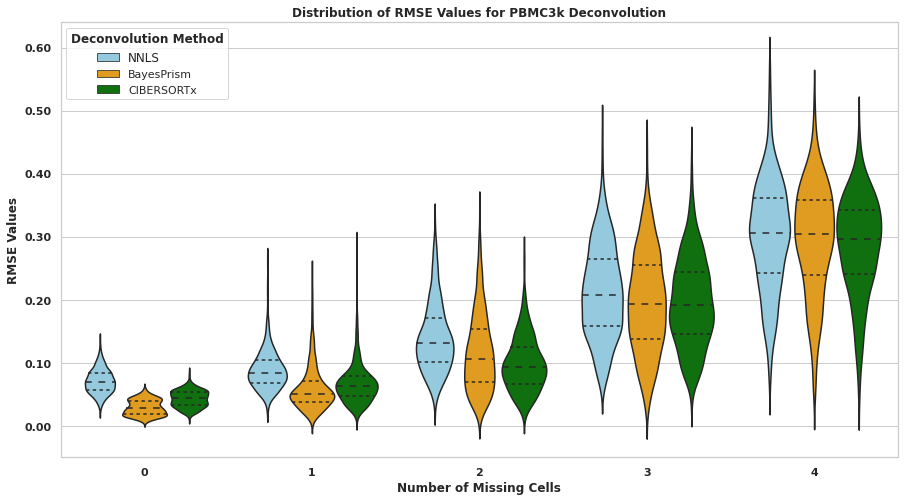

In [48]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create violin plots
plt.figure(figsize=(15, 8))

# Specify font properties
font_properties = {'family': 'Arial', 'weight': 'bold'}

# Create the violin plot
violin = sns.violinplot(x="num", y="value", hue="experiment", data=all_rmse.melt(id_vars=["num"], var_name="experiment", value_name="value"), 
                inner="quartile", palette=["skyblue", "orange", "green"], dodge=True)

# Set font properties for x-axis and y-axis
violin.set_xlabel("Number of Missing Cells", fontdict=font_properties)
violin.set_ylabel("RMSE Values", fontdict=font_properties)
violin.set_title("Distribution of RMSE Values for PBMC3k Deconvolution", fontdict=font_properties)

# Set font properties for legend
legend = violin.get_legend()
legend.set_title("Deconvolution Method", prop=font_properties)
legend.texts[0].set_fontsize(12)  # Set font size for legend items

# Set font properties for tick labels
violin.set_xticklabels(violin.get_xticklabels(), font_properties)
violin.set_yticklabels([f'{val:.2f}' for val in violin.get_yticks()], font_properties)  # Round y-axis values to 2 decimals
violin.set_ylim(-0.05, .64)
# Set legend location to upper left
legend._loc = 2
# Show the plot
plt.show()
